In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData
import scipy as sp
import scipy.stats
from gprofiler import GProfiler
import pickle
from adjustText import adjust_text
from matplotlib import gridspec
# Other specific functions 
from itertools import product
from statsmodels.stats.multitest import multipletests
import time
import os

import sys
sys.path.insert(1, '../')
import util

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.11.0


In [2]:
# GLOBAL VARIABLES
DATA_PATH = '/n/groups/price/martin/tms_gene_data'
DGE_RES_PATH = DATA_PATH + '/DGE_result'
DGE_RES_PATH_OLD = DATA_PATH + '/DE_result_old'
ANNO_DATA_PATH = DATA_PATH + '/annotation_data'
RESULT_PATH = DATA_PATH + '/result_v1'

METHOD_LIST = ['facs', 'droplet']
DIC_METHOD_NAME = {'facs':'FACS', 'droplet':'droplet'}
CELLCATE_LIST = ['immune', 'stem cell/progenitor', 'stromal', 'endothelial', 'epithelial', 'parenchymal']

### Load data

In [3]:
# Load the data obs df: facs
temp_data = util.load_normalized_data(DATA_PATH, data_name='facs', total_ct_per_cell=1e4,
                                      flag_size_factor=False, flag_log1p=False)
gene_list_facs = list(temp_data.var_names)
gene_list_facs.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_facs = temp_data.obs.copy()
df_obs_facs['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_facs['tissue'],
                                                       df_obs_facs['cell_ontology_class'])]

# Load the data obs df: droplet
temp_data = util.load_normalized_data(DATA_PATH, data_name='droplet',
                                      flag_size_factor=False, flag_log1p=False)
gene_list_droplet = list(temp_data.var_names)
gene_list_droplet.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_droplet = temp_data.obs.copy()
df_obs_droplet['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_obs_droplet['tissue'], 
                                                          df_obs_droplet['cell_ontology_class'])]

# Load the data obs df: bulk
temp_data = util.load_normalized_data_bulk(DATA_PATH, flag_size_factor=False, flag_log1p=False)
gene_list_bulk = list(temp_data.var_names)
gene_list_bulk.sort()
temp_data.obs['n_genes'] = (temp_data.X>0).sum(axis=1)
df_obs_bulk = temp_data.obs.copy()
df_obs_bulk['analyte'] = df_obs_bulk['tissue']

# dic for obs
dic_obs = {'facs':df_obs_facs, 'droplet':df_obs_droplet, 'bulk':df_obs_bulk}
dic_gene_list = {'facs':gene_list_facs, 'droplet':gene_list_droplet, 'bulk':gene_list_bulk}

# del temp results
del temp_data

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


### Load DGE results

In [4]:
# Load DGE results
df_info_facs,dic_dge_facs = util.load_DGE_res(DATA_PATH, dname='facs.tc',version='1e4')
df_info_droplet,dic_dge_droplet = util.load_DGE_res(DATA_PATH, dname='droplet.tc',version='1e4')

# Change analyte name
temp_list = list(dic_dge_facs.keys())
for analyte in temp_list:
    tissue,cell_type = analyte.split('.')
    cell_type = cell_type.replace('_', ' ')
    dic_dge_facs['%s.%s'%(tissue,cell_type)] = dic_dge_facs[analyte].copy()
    if '%s.%s'%(tissue,cell_type) != analyte: del dic_dge_facs[analyte]

temp_list = list(dic_dge_droplet.keys())
for analyte in temp_list:
    tissue,cell_type = analyte.split('.')
    cell_type = cell_type.replace('_', ' ')
    dic_dge_droplet['%s.%s'%(tissue,cell_type)] = dic_dge_droplet[analyte].copy()
    if '%s.%s'%(tissue,cell_type) != analyte:  del dic_dge_droplet[analyte]
        
# fixit: update bh_p (not sure if this is necessary)
dic_dge = {'facs':dic_dge_facs, 'droplet':dic_dge_droplet}

# Append tissue-level results
df_info_facs_tissue,dic_dge['facs.tissue'] = util.load_DGE_res(DATA_PATH, dname='facs.tissue', version='1e4')
df_info_droplet_tissue,dic_dge['droplet.tissue'] = util.load_DGE_res(DATA_PATH, dname='droplet.tissue',
                                                                     version='1e4')
df_info_bulk_tissue,dic_dge['bulk.tissue'] = util.load_DGE_res(DATA_PATH, dname='bulk.tissue', version='1e4')

In [5]:
# dic_analysis_list and dic_fdr_threshold

# analysis list: facs
min_cell_number = 100
ind_select = (df_info_facs['n_cell_young']>min_cell_number) & (df_info_facs['n_cell_old']>min_cell_number)
analysis_list_facs = list(df_info_facs.index[ind_select])

# analysis list: droplet
min_cell_number = 500
ind_select = (df_info_droplet['n_cell_young']>min_cell_number) & (df_info_droplet['n_cell_old']>min_cell_number)
analysis_list_droplet = list(df_info_droplet.index[ind_select])

dic_analysis_list = {'facs':analysis_list_facs, 'droplet':analysis_list_droplet}
for method in METHOD_LIST:
    print('%s, n_tc=%d'%(method, len(dic_analysis_list[method])))

# thresholds parameters
coef_threshold = 0.005
dic_fdr_threshold = {'facs':0.01, 'droplet':0.01, 'bulk':0.1}

facs, n_tc=76
droplet, n_tc=26


In [6]:
# Structured DGE results
dic_H_p = {}
dic_H_fdr = {}
dic_coef = {}
dic_coef_z = {}
dic_coef_se = {}
dic_coef_p = {}
dic_coef_fdr = {}

for method in METHOD_LIST:
    
    dic_H_p[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_H_fdr[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_z[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_se[method] = pd.DataFrame(index = dic_gene_list[method])
    
    dic_coef_p[method] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_fdr[method] = pd.DataFrame(index = dic_gene_list[method])
    
    for analyte in dic_analysis_list[method]:
        
        dic_H_p[method][analyte] = dic_dge[method][analyte]['age.H_p']
        dic_H_fdr[method][analyte] = dic_dge[method][analyte]['age.H_fdr']
        dic_coef[method][analyte] = dic_dge[method][analyte]['age.logFC']
        dic_coef_z[method][analyte] = dic_dge[method][analyte]['age.logFC_z']
        dic_coef_se[method][analyte] = dic_dge[method][analyte]['age.logFC']/\
                                        dic_dge[method][analyte]['age.logFC_z']
        
        temp_v = dic_dge[method][analyte]['age.logFC_z']
        temp_gene_list = list(dic_dge[method][analyte].index)
        temp_v_p = (1-sp.stats.norm.cdf(np.absolute(temp_v)))*2
        temp_v_p[np.isnan(temp_v_p)] = 1
        temp_v_fdr = multipletests(temp_v_p, method='fdr_bh')[1]
        
        dic_coef_p[method].loc[temp_gene_list, analyte] = temp_v_p
        dic_coef_fdr[method].loc[temp_gene_list, analyte] = temp_v_fdr
        
    # na values
    dic_H_p[method] = dic_H_p[method].fillna(1)
    dic_H_fdr[method] = dic_H_fdr[method].fillna(1)
    dic_coef[method] = dic_coef[method].fillna(0)    
    dic_coef_z[method] = dic_coef_z[method].fillna(0)    
    dic_coef_se[method] = dic_coef_se[method].fillna(1e6)
    
    dic_coef_p[method] = dic_coef_p[method].fillna(1)
    dic_coef_fdr[method] = dic_coef_fdr[method].fillna(1)

/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jz286/myenv/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [7]:
# Structured DGE results: append tissue-level results 
for method in METHOD_LIST+['bulk']:
    tissue_list = list(dic_dge['%s.tissue'%method])
    tissue_list.sort()
    keyname = '%s.tissue'%method
        
    dic_H_p[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_H_fdr[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_z[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_se[keyname] = pd.DataFrame(index = dic_gene_list[method])

    dic_coef_p[keyname] = pd.DataFrame(index = dic_gene_list[method])
    dic_coef_fdr[keyname] = pd.DataFrame(index = dic_gene_list[method])

    for analyte in tissue_list:

        dic_H_p[keyname][analyte] = dic_dge[keyname][analyte]['age.H_p']
        dic_H_fdr[keyname][analyte] = dic_dge[keyname][analyte]['age.H_fdr']
        dic_coef[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC']
        dic_coef_z[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC_z']
        dic_coef_se[keyname][analyte] = dic_dge[keyname][analyte]['age.logFC']/\
                                        dic_dge[keyname][analyte]['age.logFC_z']

        temp_v = dic_dge[keyname][analyte]['age.logFC_z']
        temp_gene_list = list(dic_dge[keyname][analyte].index)
        temp_v_p = (1-sp.stats.norm.cdf(np.absolute(temp_v)))*2
        temp_v_p[np.isnan(temp_v_p)] = 1
        temp_v_fdr = multipletests(temp_v_p, method='fdr_bh')[1]

        dic_coef_p[keyname].loc[temp_gene_list, analyte] = temp_v_p
        dic_coef_fdr[keyname].loc[temp_gene_list, analyte] = temp_v_fdr

    # na values
    dic_H_p[keyname] = dic_H_p[keyname].fillna(1)
    dic_H_fdr[keyname] = dic_H_fdr[keyname].fillna(1)
    dic_coef[keyname] = dic_coef[keyname].fillna(0)    
    dic_coef_z[keyname] = dic_coef_z[keyname].fillna(0)    
    dic_coef_se[keyname] = dic_coef_se[keyname].fillna(1e6)

    dic_coef_p[keyname] = dic_coef_p[keyname].fillna(1)
    dic_coef_fdr[keyname] = dic_coef_fdr[keyname].fillna(1)

### Load annotations

In [8]:
# df_cell_category
df_cell_category = pd.read_csv(ANNO_DATA_PATH + '/cell_ontology_class_functional_annotation.073020.tsv',
                               header=0, index_col=None, sep='\t')
df_cell_category = df_cell_category.fillna('')

df_cell_category['analyte'] = ['%s.%s'%(x,y) for x,y in zip(df_cell_category['tissue'],
                                                            df_cell_category['cell_ontology_class'])]
df_cell_category.index = df_cell_category['analyte']

df_cell_category = df_cell_category[['cell category', 'turnover_mouse', 'binary_lifespan']]

In [9]:
# Analyte annotation
dic_anno = {x:pd.DataFrame(index=dic_analysis_list[x])
            for x in METHOD_LIST}

for method in METHOD_LIST:
    # tissue and cell_ontology_class
    dic_anno[method]['tissue'] = [x.split('.')[0] for x in dic_anno[method].index]
    dic_anno[method]['cell_ontology_class'] = [x.split('.')[1] for x in dic_anno[method].index]
    
    # n_cell
    dic_anno[method]['n_cell'] = [((dic_obs[method]['tissue']==x.split('.')[0]) & 
                                   (dic_obs[method]['cell_ontology_class']==x.split('.')[1])).sum() 
                                  for x in dic_anno[method].index]
    
    # n_celltype in the tissue
    temp_dic = {x:(dic_anno[method]['tissue']==x).sum() for x in set(dic_anno[method]['tissue'])}
    dic_anno[method]['n_celltype'] = [temp_dic[x] for x in dic_anno[method]['tissue']]
    
    # n_rej
    dic_anno[method]['n_rej'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                        (np.absolute(dic_coef[method][x])>coef_threshold))
                                 for x in dic_anno[method].index]
    
    dic_anno[method]['n_rej.up'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                           (dic_coef[method][x]>coef_threshold))
                                    for x in dic_anno[method].index]
    
    dic_anno[method]['n_rej.down'] = [np.sum((dic_H_fdr[method][x]<dic_fdr_threshold[method]) &
                                             (dic_coef[method][x]<-coef_threshold))
                                      for x in dic_anno[method].index]
    
    
    dic_anno[method] = dic_anno[method].join(df_cell_category)

In [10]:
# Gene partition results
dic_gene_anno = {}
for method in METHOD_LIST:
    
    dic_gene_anno[method] = pd.read_csv(DATA_PATH+'/result_v1/tms_gene_table/gene_stats_%s.gz'%method,
                                        sep='\t', index_col=False, header=0, compression='gzip')
    dic_gene_anno[method].index = dic_gene_anno[method]['gene']
    
for method in METHOD_LIST+['bulk']:
    dic_gene_anno['%s.tissue'%method] = pd.read_csv(DATA_PATH+'/result_v1/tms_gene_table/gene_stats_%s_tissue.gz'
                                                    %method, sep='\t', index_col=False, header=0,
                                                    compression='gzip')
    dic_gene_anno['%s.tissue'%method].index = dic_gene_anno['%s.tissue'%method]['gene']

/home/jz286/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Figure: global aging genes (./result_v1/fig_GAG)

In [11]:
for method in METHOD_LIST:
    print('# %-20s %-5d aging related genes   %-3d GAGs'
          %(method, (dic_gene_anno[method]['prop_sig_w'].values>0).sum(),
            (dic_gene_anno[method]['global']).sum()))
    
for method in METHOD_LIST+['bulk']:
    keyname = '%s.tissue'%method
    print('# %-20s %-5d aging related genes   %-3d GAGs'
          %(keyname, (dic_gene_anno[keyname]['prop_sig_w'].values>0).sum(),
            (dic_gene_anno[keyname]['global']).sum()))

# facs                 13376 aging related genes   330 GAGs
# droplet              6233  aging related genes   59  GAGs
# facs.tissue          9551  aging related genes   147 GAGs
# droplet.tissue       6071  aging related genes   48  GAGs
# bulk.tissue          1719  aging related genes   0   GAGs


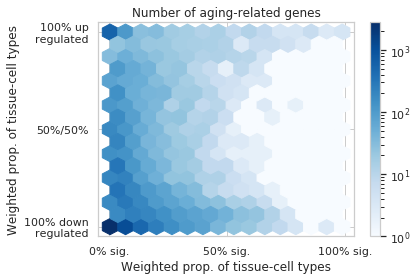

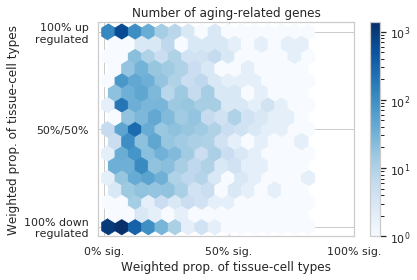

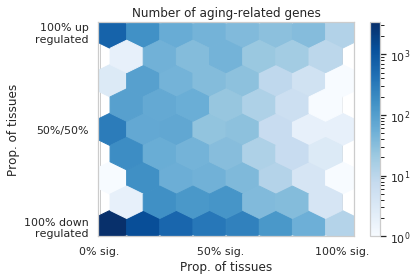

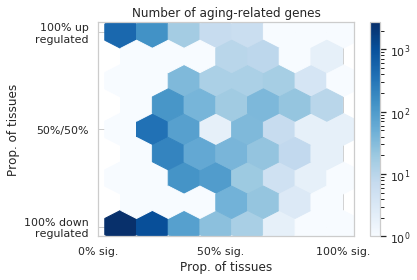

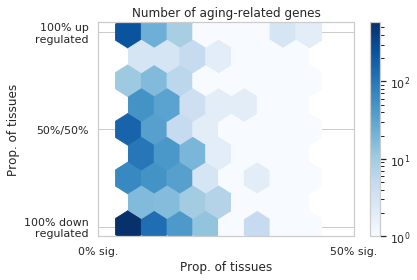

In [12]:
for method in METHOD_LIST:
    ind_select = dic_gene_anno[method]['prop_sig_w']>0
    df_plot = dic_gene_anno[method].loc[ind_select]

    plt.figure(figsize=[6,4])

    plt.hexbin(df_plot['prop_sig_w'], df_plot['prop_upreg_w'], gridsize=15,
               cmap = 'Blues', bins='log')    
    plt.colorbar()

    plt.ylabel('Weighted prop. of tissue-cell types')
    plt.xlabel('Weighted prop. of tissue-cell types')

    plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    plt.title('Number of aging-related genes')
    plt.tight_layout()
    plt.savefig(DATA_PATH+'/result_v1/fig_GAG/aging_gene_count_%s.pdf'%method)
    plt.show()
    
for method in METHOD_LIST+['bulk']:
    ind_select = dic_gene_anno['%s.tissue'%method]['prop_sig_w']>0
    df_plot = dic_gene_anno['%s.tissue'%method].loc[ind_select]

    plt.figure(figsize=[6,4])

    plt.hexbin(df_plot['prop_sig_w'], df_plot['prop_upreg_w'], gridsize=7,
               cmap = 'Blues', bins='log')    
    plt.colorbar()

    plt.ylabel('Prop. of tissues')
    plt.xlabel('Prop. of tissues')

    if method=='bulk':
        plt.xticks([0, 0.5], ['0% sig.', '50% sig.'])
    else:
        plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
        
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    plt.title('Number of aging-related genes')
    plt.tight_layout()
    plt.savefig(DATA_PATH+'/result_v1/fig_GAG/aging_gene_count_%s_tissue.pdf'%method)
    plt.show()

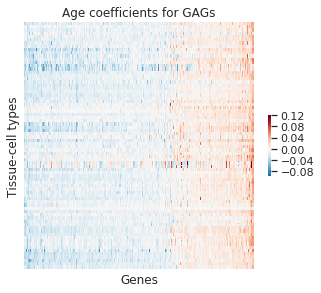

In [13]:
# Figure: all GAGs
gag_list = list(dic_gene_anno['facs']
                .loc[dic_gene_anno['facs']['global'], 'gene'].values)

df_plot = dic_coef['facs'].loc[gag_list].copy()
df_plot = df_plot.fillna(value=0)
ind_sort = list(np.argsort(df_plot.median(axis=1)))
df_plot = df_plot.iloc[ind_sort]
df_plot = df_plot.T

plt.figure(figsize = [0.014*df_plot.shape[1], 0.055*df_plot.shape[0]])
sns.heatmap(df_plot, xticklabels=False, yticklabels=False,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.25})
plt.xlabel('Genes')
plt.ylabel('Tissue-cell types')
plt.title('Age coefficients for GAGs')
plt.tight_layout()
plt.savefig(DATA_PATH+'/result_v1/fig_GAG/gag_heatmap_small.pdf',
            bbox_inches='tight', transparent=True)
plt.show()

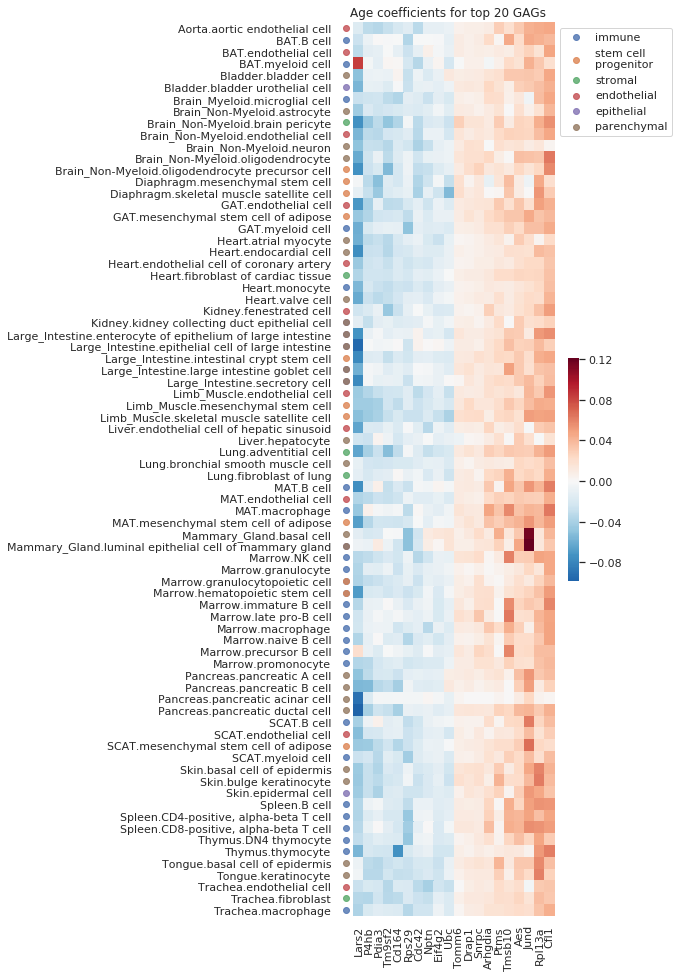

In [14]:
# Heatmap of top 20 global aging genes (10 up and 10 down)
temp_df = dic_gene_anno['facs'][['gene', 'prop_upreg_w', 'prop_sig_w', 'global']].copy()
temp_df = temp_df.sort_values(by=['prop_sig_w'], ascending=False)
temp_list1 = list(temp_df.loc[temp_df['prop_upreg_w']>0.8, 'gene'].values[0:10])
temp_list2 = list(temp_df.loc[temp_df['prop_upreg_w']<0.2, 'gene'].values[0:10])
top_gag_list = temp_list1 + temp_list2

# Figure: top 20 GAGs
df_plot = dic_coef['facs'].loc[top_gag_list].copy()
df_plot = df_plot.fillna(value=0)
ind_sort = list(np.argsort(df_plot.median(axis=1)))
df_plot = df_plot.iloc[ind_sort]
df_plot = df_plot.T

plt.figure(figsize = [0.37*df_plot.shape[1]+1.5, 0.18*df_plot.shape[0]])
sns.heatmap(df_plot, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.25})
# Category annotation
for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
    ind_select = np.array([cellcate in dic_anno['facs'].loc[x, 'cell category']
                           for x in df_plot.index])
    plt.scatter([-0.75]*ind_select.sum(), 
                np.arange(ind_select.shape[0])[ind_select]+0.5, 
                color='C%d'%i_cellcate, alpha=0.8, label=cellcate.replace('/', '\n'))
plt.xlim([-1.25, df_plot.shape[1]])
plt.legend(loc="upper left", bbox_to_anchor=(1,1))

plt.title('Age coefficients for top 20 GAGs')
plt.tight_layout()
plt.savefig(DATA_PATH+'/result_v1/fig_GAG/top_GAG_heatmap.pdf',
            bbox_inches='tight', transparent=True)
plt.show()

In [15]:
# Interesting gene sets
dic_geneset = {}

# 272 global aging genes in the initial submission
temp_df = pd.read_excel(DATA_PATH+'/results/tms_gene_table/tc.global_aging.xls', index_col=0)
dic_geneset['GAG_old'] = list(temp_df.index)

# Global aging genes in Kimmel et al 
temp_df=pd.read_csv(DATA_PATH+'/Kimmel_GR_2019_data/20200522_mzhang/joint_common_dex_genes_k5.csv',
                    header=None)
dic_geneset['Kimmel_GAG'] = list(temp_df[0])

# AgeGen genes
temp_df = pd.read_csv(DATA_PATH+'/annotation_data/GenAge/genage_models.csv')
temp_df = temp_df.loc[temp_df['organism'] == 'Mus musculus']
dic_geneset['GenAge.mouse'] = list(set(temp_df['symbol'].values))

# AgeGen: human
temp_df = pd.read_csv(DATA_PATH+'/annotation_data/GenAge/genage_human.csv')
gp = GProfiler(return_dataframe=True)
df_orth = gp.orth(organism='hsapiens', query=list(temp_df['symbol'].values), target='mmusculus')
dic_geneset['GenAge.human'] = list(set(df_orth.loc[~df_orth['name'].isna(), 'name'].values))

# Senescence gene
temp_df = pd.read_csv(DATA_PATH+'/annotation_data/senescence_227.txt', header=None)
dic_geneset['Senescence'] = list(temp_df[0].values)

# TF genes
temp_df = pd.read_csv(DATA_PATH+'/annotation_data/GO_term_summary_20171110_222852.csv')
dic_geneset['TF'] = list(set(temp_df['Symbol'].values))

# Eif 
dic_geneset['Eif'] = [x for x in dic_gene_list['facs'] if x[0:3]=='Eif']

# Rpl/Rps
dic_geneset['Rpl/Rps'] = [x for x in dic_gene_list['facs'] if (x[0:3]=='Rpl') | (x[0:3]=='Rps')]
# # Rpl, Rps, Eif
# for gs_name in ['Rpl', 'Rps', 'Eif']:
#     dic_geneset[gs_name] = [x for x in dic_gene_list['facs'] if x[0:3]==gs_name]
    
# Tissue-level GAGs
dic_geneset['GAG_facs_tissue'] = list(dic_gene_anno['facs.tissue'].index[dic_gene_anno['facs.tissue']['global']])
dic_geneset['GAG_facs'] = list(dic_gene_anno['facs'].index[dic_gene_anno['facs']['global']])
dic_geneset['GAG_droplet_tissue'] = list(dic_gene_anno['droplet.tissue'].index[dic_gene_anno['droplet.tissue']['global']])
dic_geneset['GAG_droplet'] = list(dic_gene_anno['droplet'].index[dic_gene_anno['droplet']['global']])

# MALACARD 
temp_df = pd.read_csv(DATA_PATH+'/annotation_data/malacard_geneset_mouse', sep='\t')
dic_geneset['mala_all'] = [] 
for col in temp_df.columns:
    dic_geneset['mala_%s'%col] = list(temp_df.loc[~temp_df[col].isna(), col])
    dic_geneset['mala_all'] += list(temp_df.loc[~temp_df[col].isna(), col])

gs_name_list = list(dic_geneset.keys())

# Summary and test for overlapping with GAGs
for method in METHOD_LIST:
    gag_list = list(dic_gene_anno[method].index[dic_gene_anno[method]['global']])
    for gs_name in gs_name_list: 
        gs_list = list(set(dic_geneset[gs_name]) & set(dic_gene_list[method]))
        OR,p_val = util.test_overlap(gs_list, gag_list, dic_gene_list[method])
        if (p_val<0.005)|('mala' not in gs_name):
            print('# %-8s GAG=%-5d %-40s intersect=%-10d p-val=%.3e'
                  %(method, len(gag_list), '%s=%d'%(gs_name,len(gs_list)),
                    len(set(gag_list)&set(gs_list)), p_val))
    print('')

# facs     GAG=330   GAG_old=292                              intersect=274        p-val=0.000e+00
# facs     GAG=330   Kimmel_GAG=239                           intersect=90         p-val=1.656e-105
# facs     GAG=330   GenAge.mouse=132                         intersect=5          p-val=4.210e-02
# facs     GAG=330   GenAge.human=296                         intersect=23         p-val=6.271e-11
# facs     GAG=330   Senescence=220                           intersect=9          p-val=4.708e-03
# facs     GAG=330   TF=1061                                  intersect=17         p-val=5.971e-01
# facs     GAG=330   Eif=57                                   intersect=6          p-val=1.647e-04
# facs     GAG=330   Rpl/Rps=101                              intersect=39         p-val=9.320e-46
# facs     GAG=330   GAG_facs_tissue=147                      intersect=138        p-val=1.135e-255
# facs     GAG=330   GAG_facs=330                             intersect=330        p-val=0.000e+00
# facs  

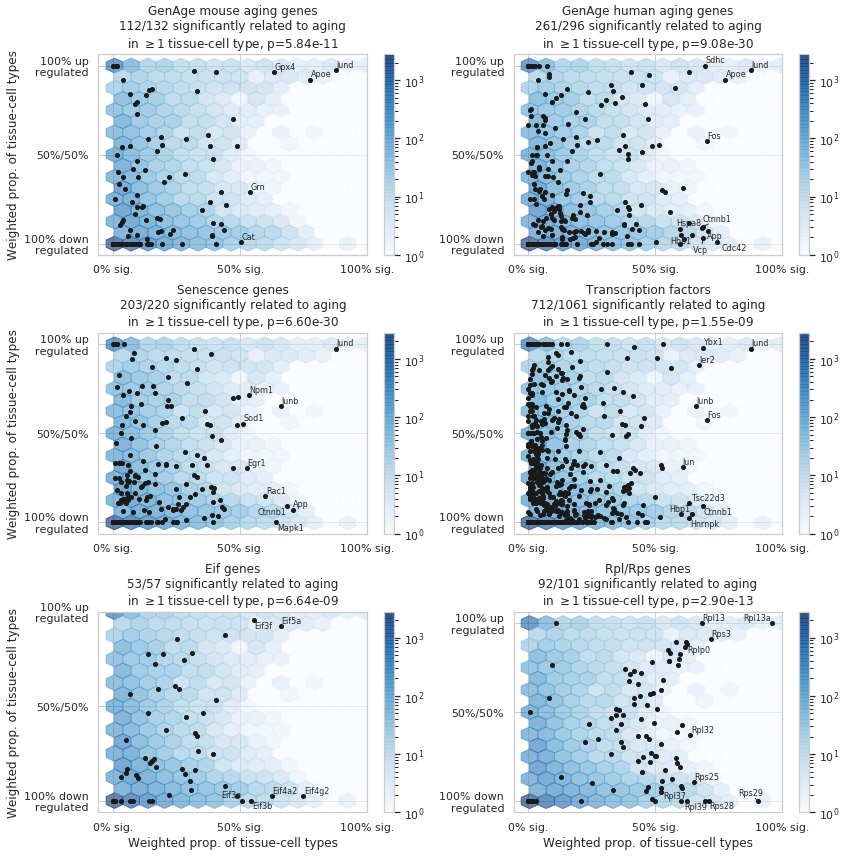

In [16]:
title_list = ['GenAge mouse aging genes', 
              'GenAge human aging genes', 
              'Senescence genes', 'Transcription factors',
              'Eif genes', 'Rpl/Rps genes']
term_list = ['GenAge.mouse', 'GenAge.human', 'Senescence', 'TF', 'Eif', 'Rpl/Rps']

method = 'facs'

gag_list = list(dic_gene_anno[method].index[dic_gene_anno[method]['global']])
aging_gene_list = list(dic_gene_anno[method].index[dic_gene_anno[method]['prop_sig_w']>0])
    
plt.figure(figsize=[12, 12])
for i_term,term in enumerate(term_list):
    
    gs_list = list(set(dic_geneset[term]) & set(dic_gene_list[method]))
    
    
    # Background scatter plot
    ind_select = dic_gene_anno[method]['prop_sig_w']>0
    df_plot = dic_gene_anno[method].loc[ind_select].copy()
    
    plt.subplot(3,2,i_term+1)
    plt.hexbin(df_plot['prop_sig_w'], df_plot['prop_upreg_w'], gridsize=15,
               cmap = 'Blues', bins='log', alpha=0.6)
    plt.colorbar()
    
    # Scatter plot for the geneset
    df_plot = dic_gene_anno[method].loc[gs_list].copy()
    plt.scatter(df_plot['prop_sig_w'], df_plot['prop_upreg_w'],
                color='k', alpha=1, s=16)
    
    if i_term%2==0:
        plt.ylabel('Weighted prop. of tissue-cell types')
    if i_term>=4:
        plt.xlabel('Weighted prop. of tissue-cell types')
    plt.xticks([0, 0.5, 1], ['0% sig.', '50% sig.', '100% sig.'])
    plt.yticks([0, 0.5, 1], ['100% down\nregulated', '50%/50%', '100% up\nregulated'])
    
    # Annotate top genes 
    texts = []
    annot_list = list(set(gs_list)&set(gag_list))
    if len(annot_list)>10:
        temp_df = dic_gene_anno[method].loc[annot_list].copy()
        temp_df = temp_df.sort_values(by=['prop_sig_w'], ascending=False)
        annot_list = list(temp_df.index[0:10])
    for gene in annot_list:
        texts.append(plt.text(df_plot.loc[gene, 'prop_sig_w'], df_plot.loc[gene, 'prop_upreg_w'],
                              gene, fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k', lw=1))

    OR,p_val = util.test_overlap(gs_list, aging_gene_list, set(dic_gene_list[method]))
    plt.title('%s\n%d/%d significantly related to aging\nin $\geq 1$ tissue-cell type, p=%0.2e'
              %(title_list[i_term], len(set(aging_gene_list) & set(gs_list)),
                len(gs_list), p_val))
plt.tight_layout()
plt.savefig(DATA_PATH+'/result_v1/fig_GAG/aging_gene_count_geneset_%s.pdf'%method)
plt.show()

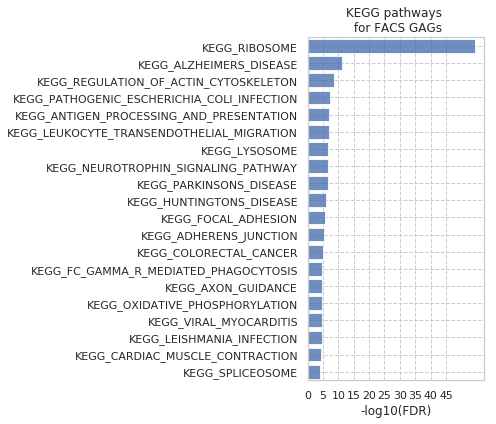

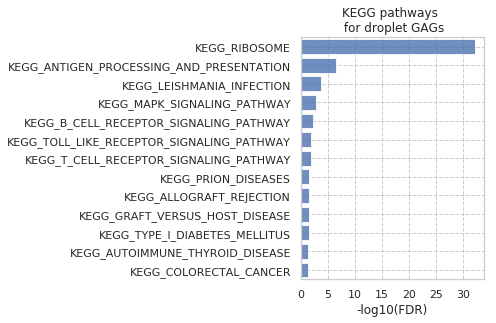

In [36]:
# KEGG gene set
for method in METHOD_LIST:
    nrow = 20 if method=='facs' else 13
    df_plot = pd.read_csv(DATA_PATH+'/GAG_%s_GSEA-KEGG.tsv'%method, sep='\t', skiprows=8, nrows=nrow)
    df_plot['nlog_fdr'] = -np.log10(df_plot['FDR q-value'].values)
    df_plot['loc'] = np.arange(df_plot.shape[0])[::-1]

    plt.figure(figsize=[7, 2+df_plot.shape[0]*0.2])
    plt.barh(df_plot['loc'], df_plot['nlog_fdr'], alpha=0.8)
    plt.yticks(df_plot['loc'].values, df_plot['Gene Set Name'], rotation=0, ha='right')
    plt.xlabel('-log10(FDR)')
    plt.ylim([-0.5, df_plot.shape[0]-0.5])
    xmin_,xmax_ = plt.xlim()
    temp_ = [5*x for x in np.arange(10) if 5*x<xmax_]
    plt.xticks(temp_, temp_)

    plt.grid(linestyle='--')
    plt.title('KEGG pathways \n for %s GAGs'%DIC_METHOD_NAME[method])
    plt.tight_layout()
    plt.savefig(DATA_PATH+'/result_v1/fig_pathway/kegg_global_%s.pdf'%method, bbox_inches='tight')
    plt.show()
    #     break

In [19]:
print(len(dic_geneset['GenAge.mouse']))
print(len(dic_geneset['GenAge.human']))
print(len(set(dic_geneset['GenAge.mouse'])&set(dic_geneset['GenAge.human'])))

136
303
97


In [17]:
# Write GAGs table
for method in METHOD_LIST:
    temp_df = dic_gene_anno[method].loc[dic_gene_anno[method]['global']]
    temp_df = temp_df[['gene', 'prop_sig_w', 'prop_upreg_w', 'median_fc', 'median_fdr']]
    temp_df = temp_df.sort_values(by='prop_sig_w', ascending=False)
    temp_df['rank'] = np.arange(temp_df.shape[0])+1
    temp_df.to_csv(DATA_PATH+'/result_v1/tms_gene_table/GAG_%s.csv'%method, index=False, sep='\t')
    temp_df.to_excel(DATA_PATH+'/result_v1/tms_gene_table/GAG_%s.xls'%method, index=False)

### Conservation between mouse and human 

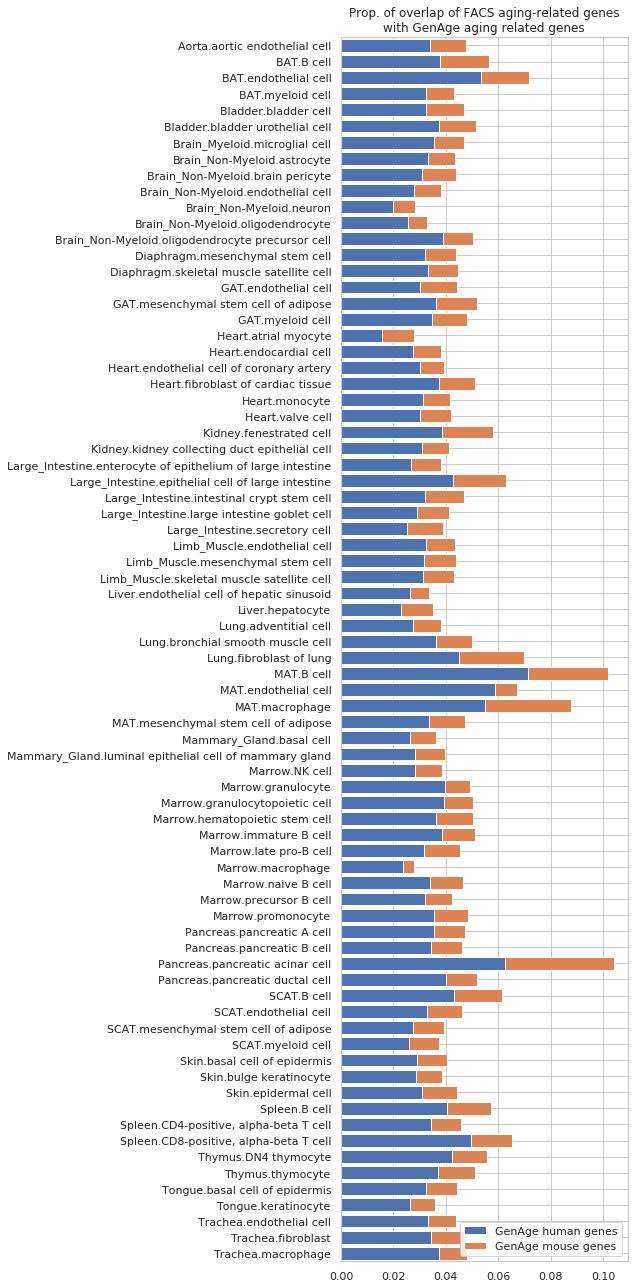

In [18]:
method='facs'
df_plot = pd.DataFrame(index=dic_analysis_list[method], columns=['n_rej', 'n_genage_mouse', 'n_genage_human'])
for analyte in dic_analysis_list[method]:
    temp_gene_list = list(dic_H_fdr[method].index[(dic_H_fdr[method][analyte]<dic_fdr_threshold[method]) &
                                                  (np.absolute(dic_coef[method][analyte])>coef_threshold)])
    df_plot.loc[analyte] = [len(temp_gene_list), len(set(temp_gene_list)&set(dic_geneset['GenAge.mouse'])),
                            len(set(temp_gene_list)&set(dic_geneset['GenAge.human']))]    
df_plot['loc'] = np.arange(df_plot.shape[0])[::-1]
df_plot['p_genage_mouse'] = df_plot['n_genage_mouse']/df_plot['n_rej']
df_plot['p_genage_human'] = df_plot['n_genage_human']/df_plot['n_rej']

plt.figure(figsize=[9,18])
plt.barh(df_plot['loc'], df_plot['p_genage_human'], height=0.8, label='GenAge human genes')
plt.barh(df_plot['loc'], df_plot['p_genage_mouse'], left=df_plot['p_genage_human'],
         height=0.8, label='GenAge mouse genes')
plt.yticks(df_plot['loc'], df_plot.index)
plt.ylim(-0.5, df_plot.shape[0]-0.5)
plt.title('Prop. of overlap of %s aging-related genes\nwith GenAge aging related genes'%DIC_METHOD_NAME[method])
plt.legend()
plt.tight_layout()
plt.savefig(DATA_PATH+'/result_v1/fig_dge/overlap_genage_%s.pdf'%method)
plt.show()

### Specific genes  (./result_v1/fig_spec)

In [19]:
# Update specific genes (to be incorporated into gene partition later)
for method in METHOD_LIST:
    
    # Write thin table 
    temp_df = pd.DataFrame()
    temp_df['gene'] = dic_gene_anno[method].index
    temp_df.index = temp_df['gene']
    temp_df['global_aging'] = dic_gene_anno[method][['global']].values
    
    temp_list = [x.replace('.fdr_dif','') for x in dic_gene_anno[method].columns 
                 if '.fdr_dif' in x] 
    temp_list.sort()
            
    for term in temp_list:
        
        v_mean_ref_p = util.get_p_two_point_v(dic_gene_anno[method]['%s.mean_ref'%term].values,
                                         dic_gene_anno[method]['%s.se_ref'%term].values)
        v_mean_ref_fdr = multipletests(v_mean_ref_p, method='fdr_bh')[1]
        
        ind_select = (dic_gene_anno[method]['%s.fdr_dif'%term]<dic_fdr_threshold[method]) &\
                        (np.absolute(dic_gene_anno[method]['%s.mean'%term])>coef_threshold) &\
                        (v_mean_ref_fdr>0.01)
        temp_gene_list = list(dic_gene_anno[method].index[ind_select])
        
        if len(temp_gene_list)>0:
            temp_df[term] = False
            temp_df.loc[temp_gene_list, term] = True
        
            print('# %-8s %-50s n_gene=%-5d overlap with FACS GAGs=%d'
                  %(method, term, len(temp_gene_list), len(set(temp_gene_list)&set(dic_geneset['GAG_facs']))))
        
    dic_gene_anno['%s_table'%method] = temp_df.copy()
    print('')

# facs     spec_celltype:B cell                               n_gene=90    overlap with FACS GAGs=2
# facs     spec_celltype:basal cell of epidermis              n_gene=249   overlap with FACS GAGs=1
# facs     spec_celltype:endothelial cell                     n_gene=45    overlap with FACS GAGs=0
# facs     spec_celltype:macrophage                           n_gene=6     overlap with FACS GAGs=0
# facs     spec_celltype:mesenchymal stem cell                n_gene=174   overlap with FACS GAGs=5
# facs     spec_celltype:mesenchymal stem cell of adipose     n_gene=98    overlap with FACS GAGs=2
# facs     spec_celltype:myeloid cell                         n_gene=38    overlap with FACS GAGs=1
# facs     spec_celltype:skeletal muscle satellite cell       n_gene=249   overlap with FACS GAGs=3
# facs     spec_func:endothelial                              n_gene=61    overlap with FACS GAGs=1
# facs     spec_func:epithelial                               n_gene=14    overlap with FACS GAGs=1


In [30]:
# Write Spec table
writer = pd.ExcelWriter(DATA_PATH+'/result_v1/tms_gene_table/tms_gene_table.xlsx', engine='xlsxwriter')
for method in METHOD_LIST:
    df_table = dic_gene_anno['%s_table'%method].copy()
    df_table = df_table.drop(labels=['gene'], axis=1)
    df_table = df_table.loc[df_table.sum(axis=1)>0]
    df_table.to_excel(writer, sheet_name='TMS %s tissue-cell'%DIC_METHOD_NAME[method], index=True)
writer.save()

In [21]:
spec_list = ['spec_func', 'spec_celltype', 'spec_tissue', 'spec_tissue_celltype']
dic_spec_name = {'spec_func': 'functional-category-specific',
                 'spec_celltype': 'cell-type-specific',
                 'spec_tissue': 'tissue-specific',
                 'spec_tissue_celltype': 'tissue-cell-type-specific'}
dic_spec_col = {'spec_func': ['cell category', 'tissue', 'cell_ontology_class'],
                'spec_celltype': ['cell_ontology_class', 'tissue'],
                 'spec_tissue': ['tissue', 'cell_ontology_class'],
                 'spec_tissue_celltype': ['tissue', 'cell_ontology_class']}

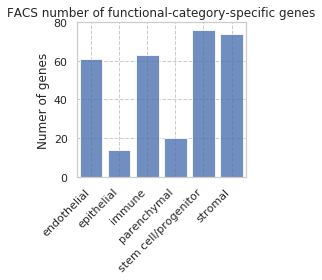

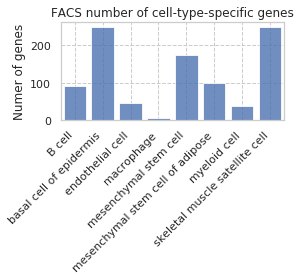

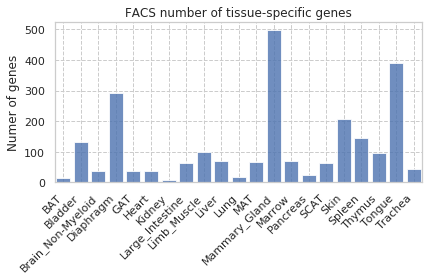

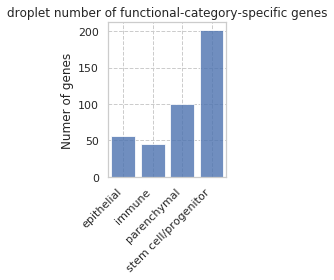

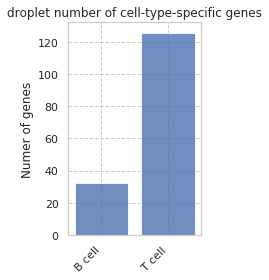

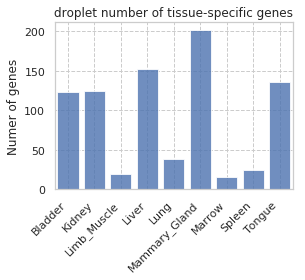

In [22]:
# Number of specific genes 
for method in METHOD_LIST:
    for spec_name in spec_list:
        
        term_list = [x for x in dic_gene_anno['%s_table'%method].columns if (spec_name in x)]
        term_list.sort()
        
        df_plot = pd.DataFrame(index=term_list)
        df_plot['n_gene'] = dic_gene_anno['%s_table'%method][term_list].sum(axis=0)
        df_plot = df_plot.loc[df_plot['n_gene']>5]
        df_plot['loc'] = np.arange(df_plot.shape[0])
        df_plot['name'] = [x.replace('%s:'%spec_name,'') for x in df_plot.index]
        
        if df_plot.shape[0]>0:
            plt.figure(figsize=[3+0.15*df_plot.shape[0], 4])
            plt.bar(df_plot['loc'], df_plot['n_gene'], alpha=0.8)
            plt.xticks(df_plot['loc'], df_plot['name'], rotation=45, ha='right')
            plt.ylabel('Numer of genes')
            plt.xlim([-0.5, df_plot.shape[0]-0.5])

            plt.grid(linestyle='--')
            plt.title('%s number of %s genes'%(DIC_METHOD_NAME[method], dic_spec_name[spec_name]))
            plt.tight_layout()
            plt.savefig(DATA_PATH+'/result_v1/fig_spec/spec_gene_ct_%s_%s.pdf'%(method, spec_name),
                        bbox_inches='tight', transparent=True)
            plt.show()

facs spec_func
spec_func:endothelial 61
spec_func:epithelial 14
spec_func:immune 63
spec_func:parenchymal 20
spec_func:stem cell/progenitor 76
spec_func:stromal 74


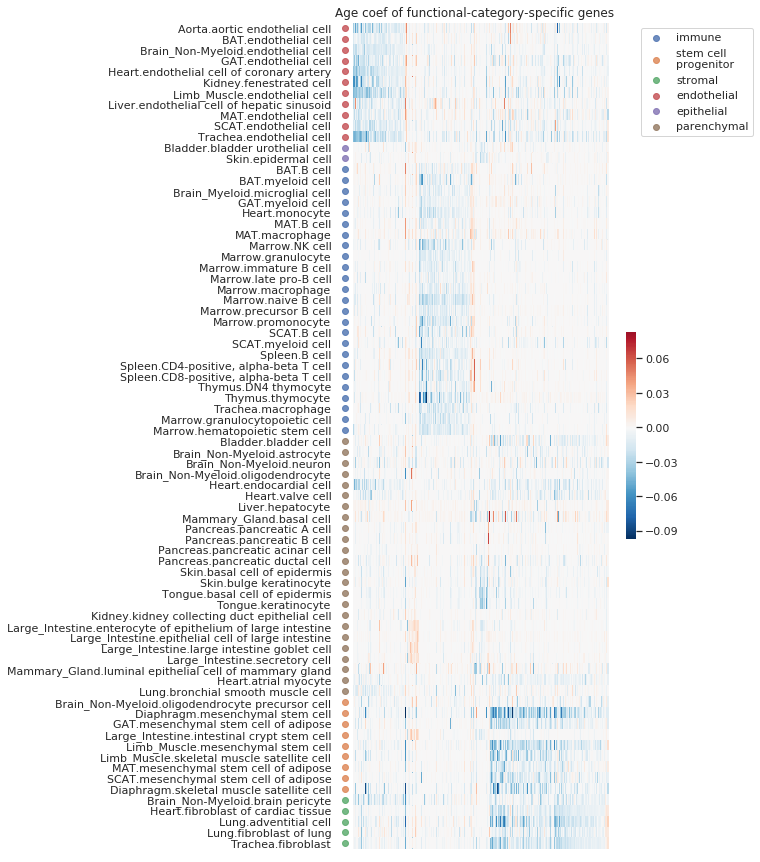

facs spec_celltype
spec_celltype:B cell 90
spec_celltype:basal cell of epidermis 249
spec_celltype:endothelial cell 45
spec_celltype:macrophage 6
spec_celltype:mesenchymal stem cell 174
spec_celltype:mesenchymal stem cell of adipose 98
spec_celltype:myeloid cell 38
spec_celltype:skeletal muscle satellite cell 249


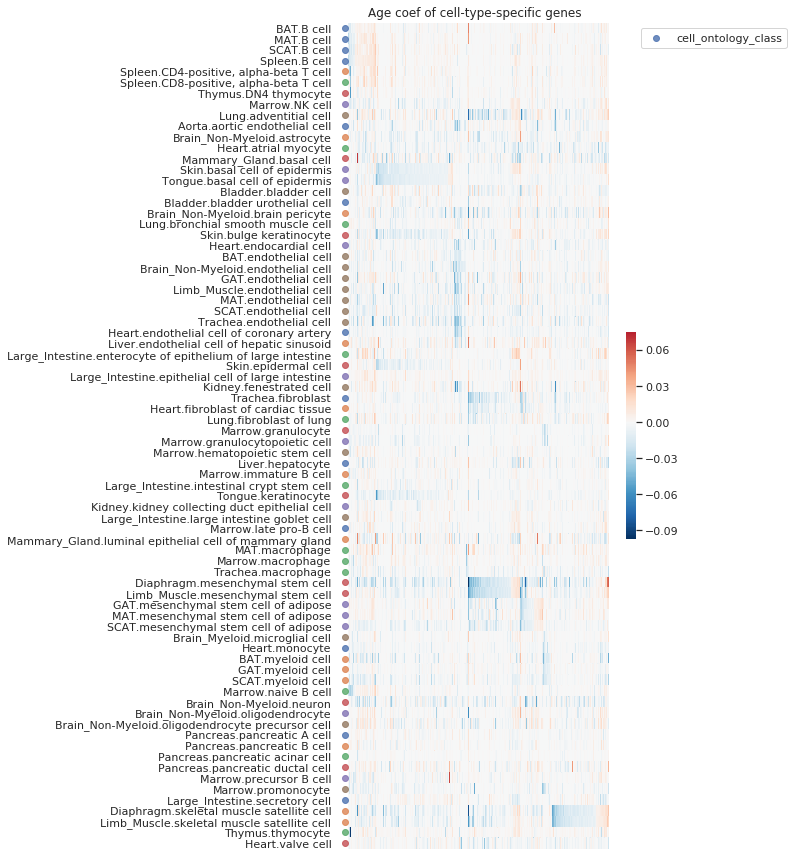

facs spec_tissue
spec_tissue:BAT 15
spec_tissue:Bladder 132
spec_tissue:Brain_Non-Myeloid 36
spec_tissue:Diaphragm 292
spec_tissue:GAT 37
spec_tissue:Heart 36
spec_tissue:Kidney 9
spec_tissue:Large_Intestine 63
spec_tissue:Limb_Muscle 99
spec_tissue:Liver 71
spec_tissue:Lung 19
spec_tissue:MAT 67
spec_tissue:Mammary_Gland 498
spec_tissue:Marrow 69
spec_tissue:Pancreas 25
spec_tissue:SCAT 64
spec_tissue:Skin 206
spec_tissue:Spleen 145
spec_tissue:Thymus 97
spec_tissue:Tongue 391
spec_tissue:Trachea 44


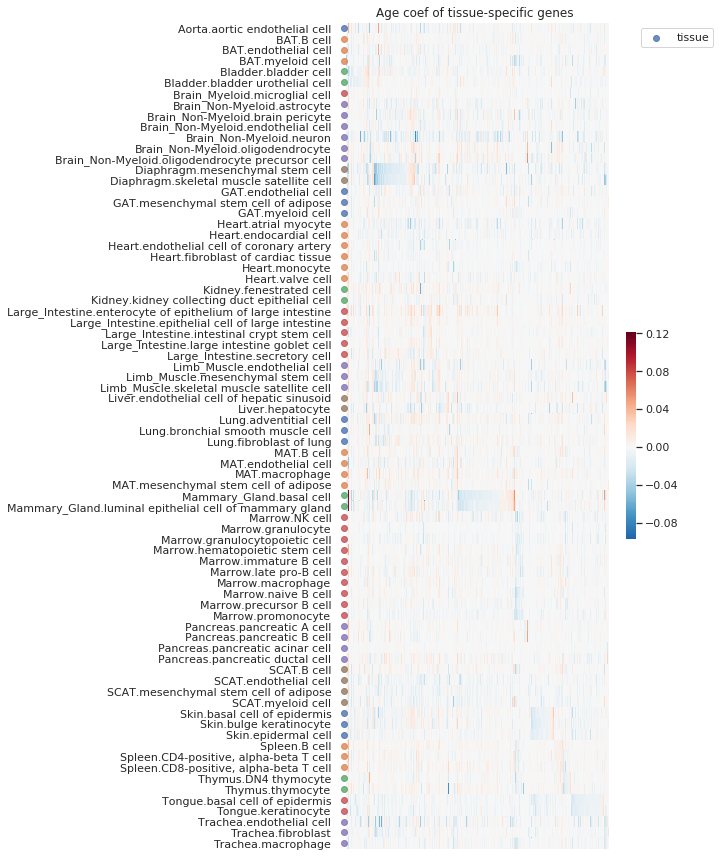

facs spec_tissue_celltype
droplet spec_func
spec_func:epithelial 56
spec_func:immune 45
spec_func:parenchymal 100
spec_func:stem cell/progenitor 202


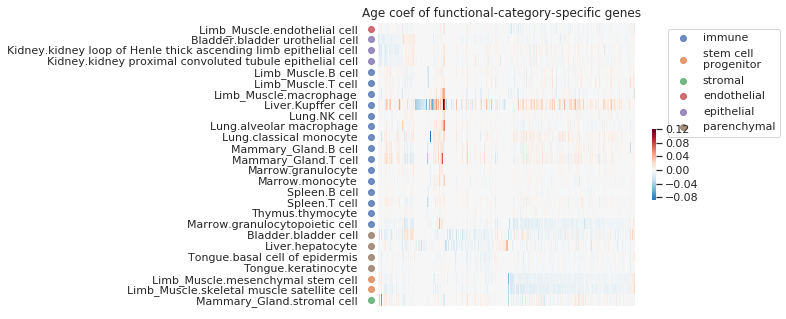

droplet spec_celltype
spec_celltype:B cell 32
spec_celltype:T cell 126


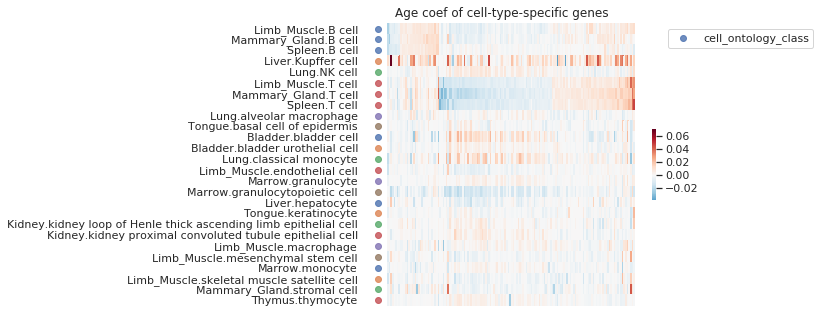

droplet spec_tissue
spec_tissue:Bladder 123
spec_tissue:Kidney 125
spec_tissue:Limb_Muscle 19
spec_tissue:Liver 152
spec_tissue:Lung 38
spec_tissue:Mammary_Gland 201
spec_tissue:Marrow 16
spec_tissue:Spleen 25
spec_tissue:Tongue 136


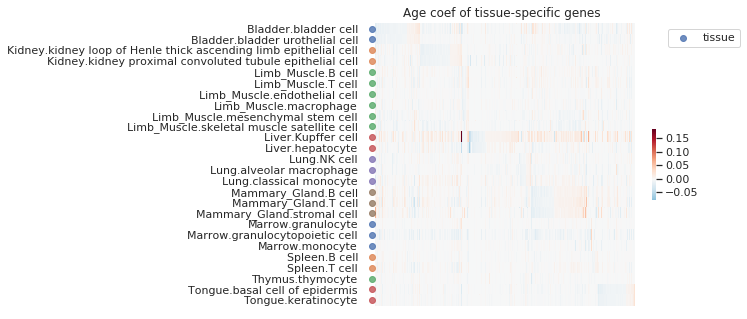

droplet spec_tissue_celltype


In [23]:
# All spec_name genes
for method in METHOD_LIST:
    for spec_name in spec_list:
        
        print(method, spec_name)
        
        term_list = [x for x in dic_gene_anno['%s_table'%method].columns if (spec_name in x)]
        term_list.sort()
        if len(term_list)==0: continue
        
        # Get gene_list        
        gene_list = []
        for term in term_list:
            temp_gene_list = list(dic_gene_anno['%s_table'%method].index[dic_gene_anno['%s_table'%method][term]])
            temp_df = dic_gene_anno[method].loc[temp_gene_list, ['%s.mean'%term]].copy()
            temp_df = temp_df.sort_values(by=['%s.mean'%term])
            gene_list += list(temp_df.index)
            print(term, len(temp_df.index))
        temp_seen = set()
        gene_list = [x for x in gene_list if (x not in temp_seen) & (temp_seen.add(x) is None)]
        
        # Get analyte list
        temp_df = dic_anno[method].sort_values(by=dic_spec_col[spec_name])
        analyte_list = list(temp_df.index)
        
        df_plot = dic_coef[method].loc[gene_list, analyte_list]
        df_plot = df_plot.T
        
        # Figure
        plt.figure(figsize = [6, 0.2*df_plot.shape[0]])
        sns.heatmap(df_plot, xticklabels=False, yticklabels=True,
                    cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.25})
        
        # Category annotation
        if spec_name=='spec_func':
            for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
                ind_select = np.array([dic_anno[method].loc[x, 'cell category'].split(';')[0]==cellcate
                                       for x in df_plot.index])
                plt.scatter([-10]*ind_select.sum(), 
                            np.arange(ind_select.shape[0])[ind_select]+0.5, 
                            color='C%d'%i_cellcate, alpha=0.8, label=cellcate.replace('/', '\n'))
        else:
            temp_list = list(set(dic_anno[method][dic_spec_col[spec_name][0]].values))
            temp_list.sort()
            for i_term,term in enumerate(temp_list):
                label = dic_spec_col[spec_name][0] if i_term==0 else None
                ind_select = np.array([dic_anno[method].loc[x, dic_spec_col[spec_name][0]]==term
                                       for x in df_plot.index])
                plt.scatter([-0.005*df_plot.shape[1]-5]*ind_select.sum(), 
                            np.arange(ind_select.shape[0])[ind_select]+0.5, 
                            color='C%d'%(i_term%6), alpha=0.8, label=label)
                
        plt.legend(loc="upper left", bbox_to_anchor=(1.1,1))
        plt.xlim([-0.015*df_plot.shape[1]-10, df_plot.shape[1]])
        
        plt.title('Age coef of %s genes'%dic_spec_name[spec_name])
        plt.savefig(DATA_PATH+'/result_v1/fig_spec/heatmap_allgene_%s_%s.pdf'%(method, spec_name),
                    transparent=True, bbox_inches='tight')
        plt.show()

facs spec_func
spec_func:endothelial 10
spec_func:epithelial 7
spec_func:immune 10
spec_func:parenchymal 10
spec_func:stem cell/progenitor 10
spec_func:stromal 10


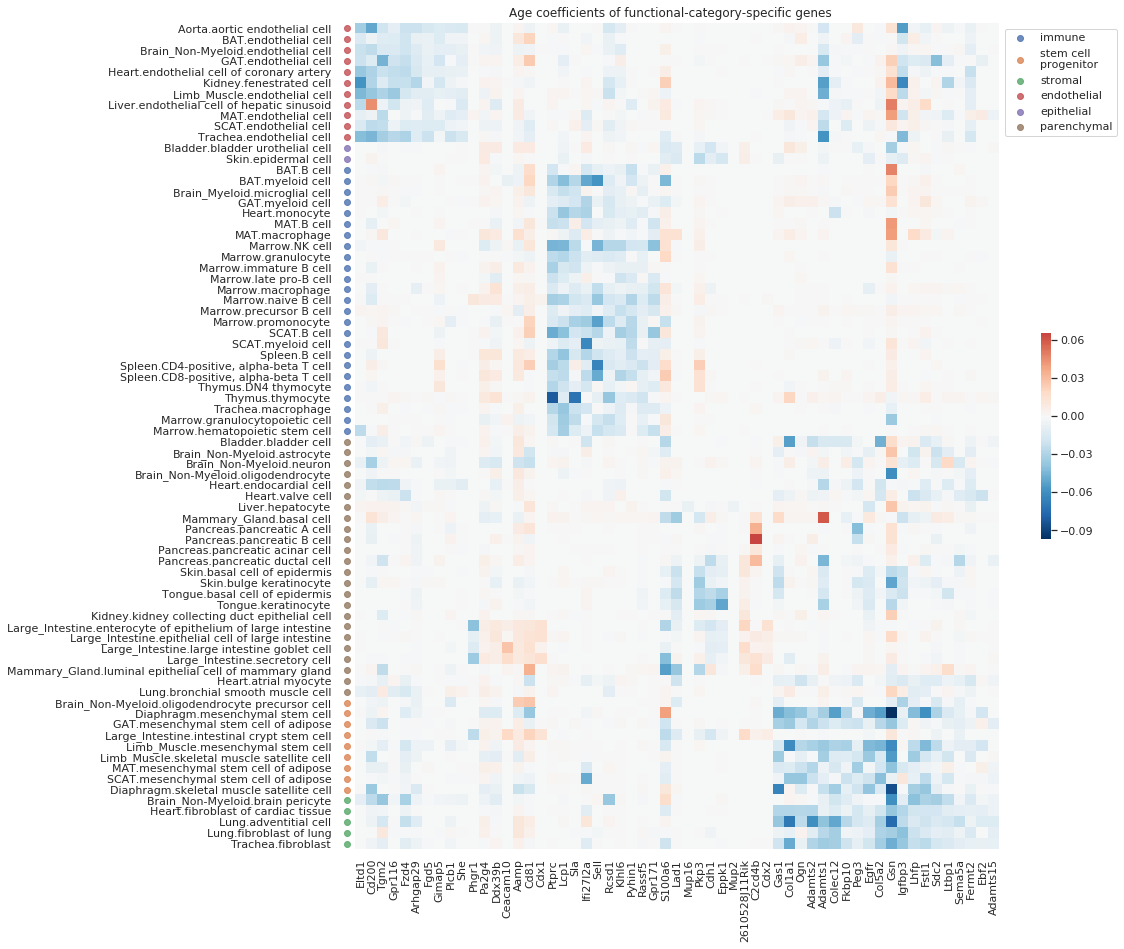

facs spec_celltype
spec_celltype:B cell 5
spec_celltype:basal cell of epidermis 5
spec_celltype:endothelial cell 5
spec_celltype:macrophage 3
spec_celltype:mesenchymal stem cell 5
spec_celltype:mesenchymal stem cell of adipose 5
spec_celltype:myeloid cell 5
spec_celltype:skeletal muscle satellite cell 5


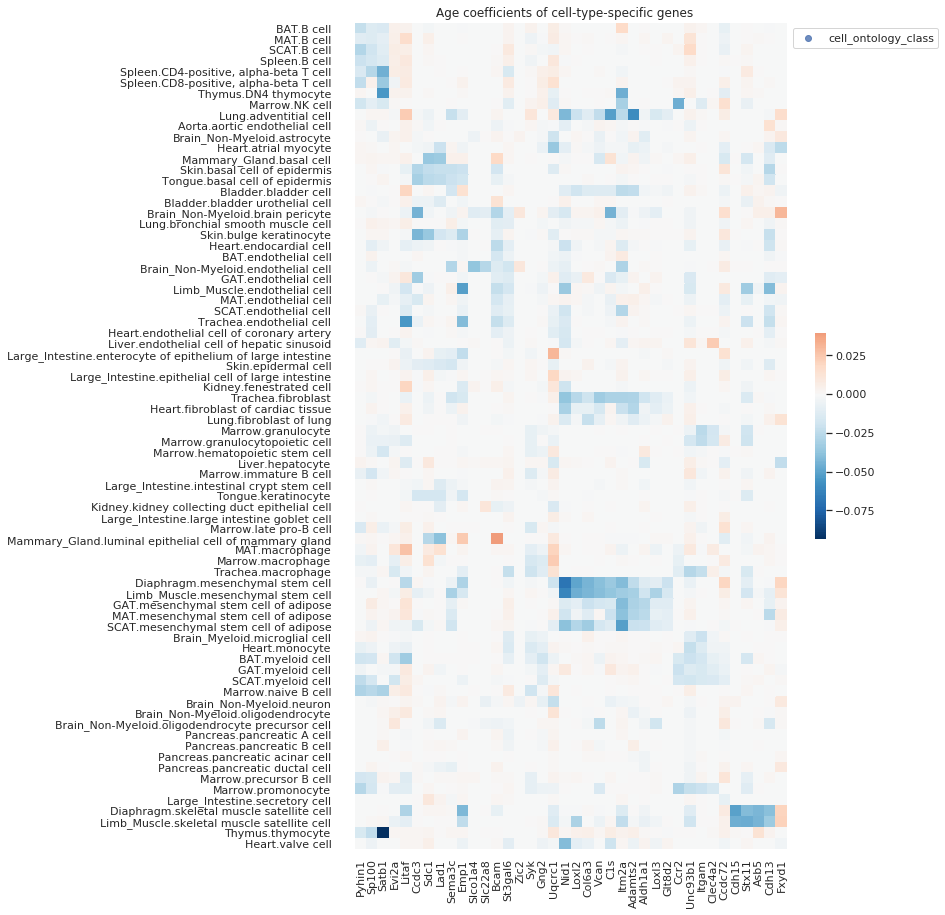

facs spec_tissue
spec_tissue:BAT 5
spec_tissue:Bladder 5
spec_tissue:Brain_Non-Myeloid 5
spec_tissue:Diaphragm 5
spec_tissue:GAT 5
spec_tissue:Heart 5
spec_tissue:Kidney 5
spec_tissue:Large_Intestine 5
spec_tissue:Limb_Muscle 5
spec_tissue:Liver 5
spec_tissue:Lung 5
spec_tissue:MAT 5
spec_tissue:Mammary_Gland 5
spec_tissue:Marrow 5
spec_tissue:Pancreas 5
spec_tissue:SCAT 5
spec_tissue:Skin 5
spec_tissue:Spleen 5
spec_tissue:Thymus 5
spec_tissue:Tongue 5
spec_tissue:Trachea 5


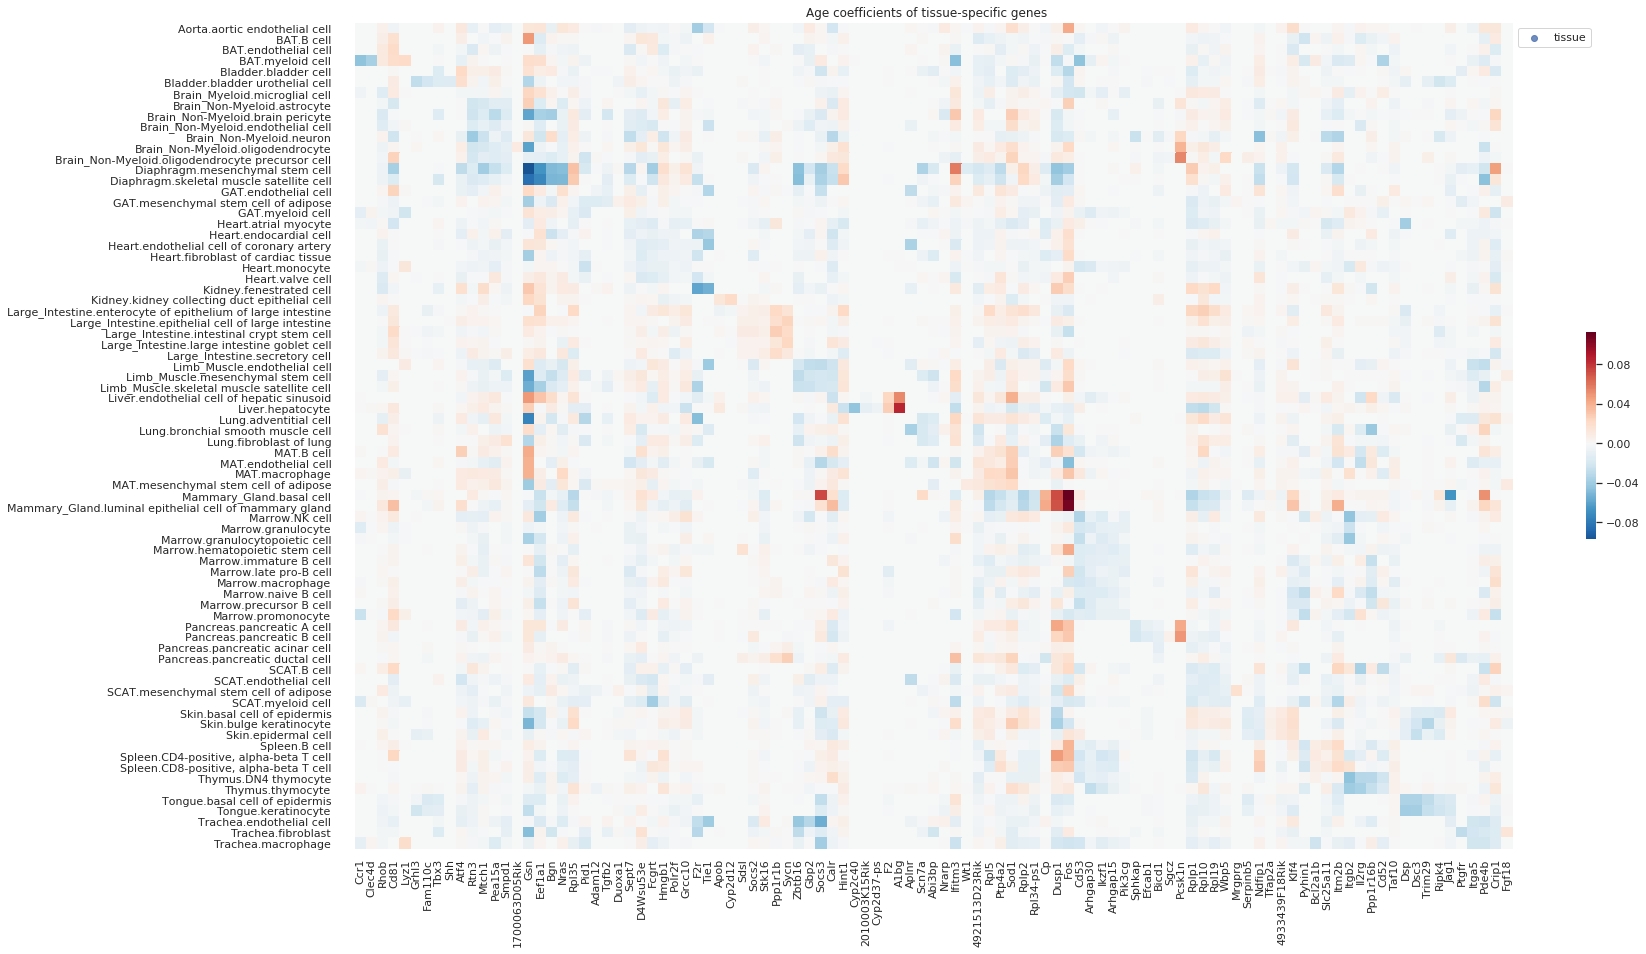

facs spec_tissue_celltype
droplet spec_func
spec_func:epithelial 10
spec_func:immune 10
spec_func:parenchymal 10
spec_func:stem cell/progenitor 10


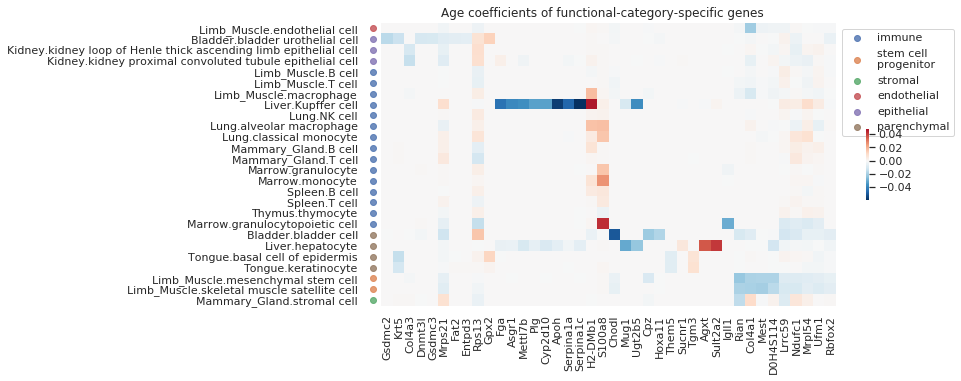

droplet spec_celltype
spec_celltype:B cell 10
spec_celltype:T cell 10


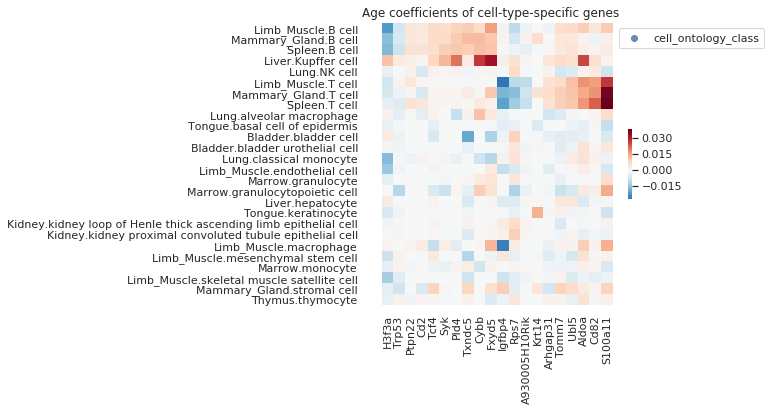

droplet spec_tissue
spec_tissue:Bladder 5
spec_tissue:Kidney 5
spec_tissue:Limb_Muscle 5
spec_tissue:Liver 5
spec_tissue:Lung 5
spec_tissue:Mammary_Gland 5
spec_tissue:Marrow 5
spec_tissue:Spleen 5
spec_tissue:Tongue 5


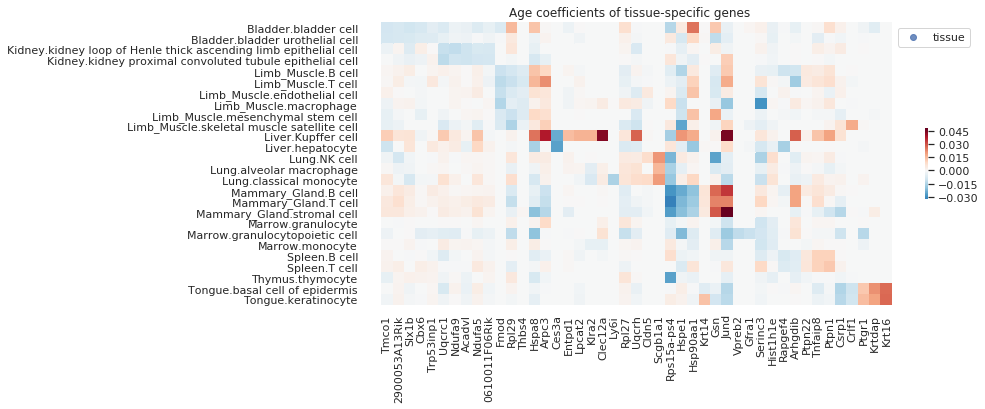

droplet spec_tissue_celltype


In [24]:
# Top spec_name genes
for method in METHOD_LIST:
    for spec_name in spec_list:
        
        print(method, spec_name)
        
        term_list = [x for x in dic_gene_anno['%s_table'%method].columns if (spec_name in x)]
        term_list.sort()
        if len(term_list)==0: continue
        
        # Get gene_list
        gene_list = []
        n_gene_per_cate = 5 + 5*(len(term_list)<8)
        for term in term_list:
            
            temp_gene_list = list(dic_gene_anno['%s_table'%method]
                                  .index[dic_gene_anno['%s_table'%method][term]])
            temp_df = dic_gene_anno[method].loc[temp_gene_list,['%s.fdr_dif'%term, '%s.mean'%term]].copy()
            temp_df = temp_df.sort_values(by=['%s.fdr_dif'%term])
            temp_df = temp_df.loc[temp_df['%s.fdr_dif'%term]<0.001]
            temp_df = temp_df.iloc[0:n_gene_per_cate]
            temp_df = temp_df.sort_values(by=['%s.mean'%term])
            gene_list += list(temp_df.index)
            print(term, len(temp_df))
        temp_seen = set()
        gene_list = [x for x in gene_list if (x not in temp_seen) & (temp_seen.add(x) is None)]
        
        # Get analyte list
        temp_df = dic_anno[method].sort_values(by=dic_spec_col[spec_name])
        analyte_list = list(temp_df.index)
        
        df_plot = dic_coef[method].loc[gene_list, analyte_list]
        df_plot = df_plot.T
        
        # Figure
        plt.figure(figsize = [0.25*df_plot.shape[1]+0.5, 0.2*df_plot.shape[0]])
        sns.heatmap(df_plot, xticklabels=True, yticklabels=True,
                    cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.25})
        
        # Category annotation
        if spec_name=='spec_func':
            for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
                ind_select = np.array([dic_anno[method].loc[x, 'cell category'].split(';')[0]==cellcate
                                       for x in df_plot.index])
                plt.scatter([-0.75]*ind_select.sum(), 
                            np.arange(ind_select.shape[0])[ind_select]+0.5, 
                            color='C%d'%i_cellcate, alpha=0.8, label=cellcate.replace('/', '\n'))
            
        else:
            temp_list = list(set(dic_anno[method][dic_spec_col[spec_name][0]].values))
            temp_list.sort()
            for i_term,term in enumerate(temp_list):
                label = dic_spec_col[spec_name][0] if i_term==0 else None
                ind_select = np.array([dic_anno[method].loc[x, dic_spec_col[spec_name][0]]==term
                                       for x in df_plot.index])
                plt.scatter([-0.005*df_plot.shape[1]-5]*ind_select.sum(), 
                            np.arange(ind_select.shape[0])[ind_select]+0.5, 
                            color='C%d'%(i_term%6), alpha=0.8, label=label)
                
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.xlim([-1.25, df_plot.shape[1]])
        
        plt.title('Age coefficients of %s genes'%dic_spec_name[spec_name])
        plt.savefig(DATA_PATH+'/result_v1/fig_spec/heatmap_topgene_%s_%s.pdf'%(method, spec_name),
                    transparent=True, bbox_inches='tight')
        plt.show()

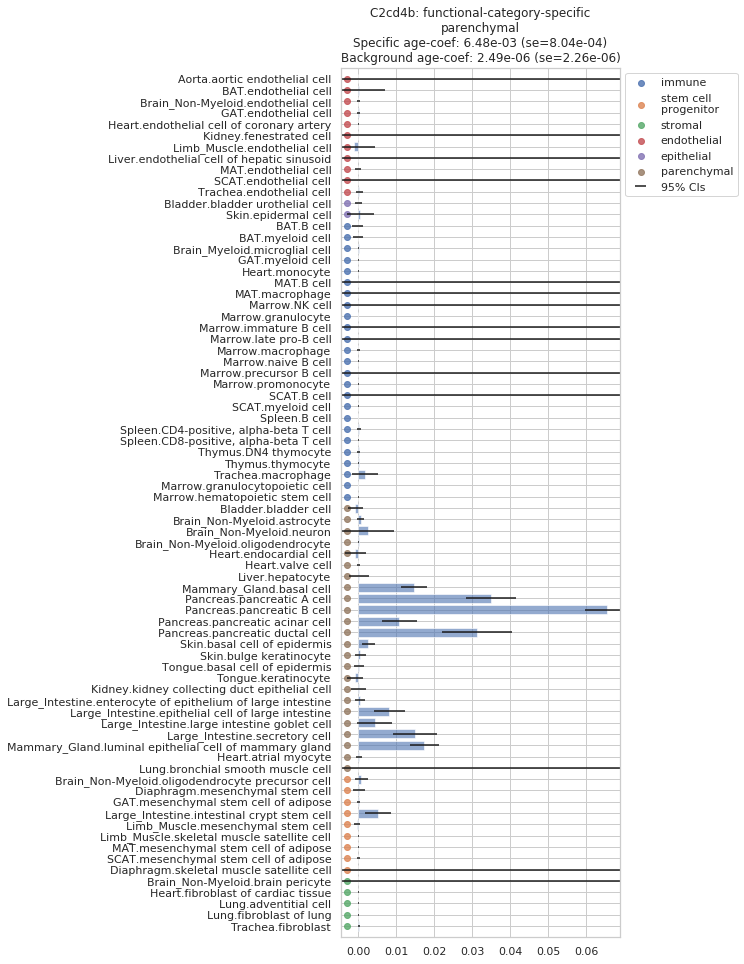

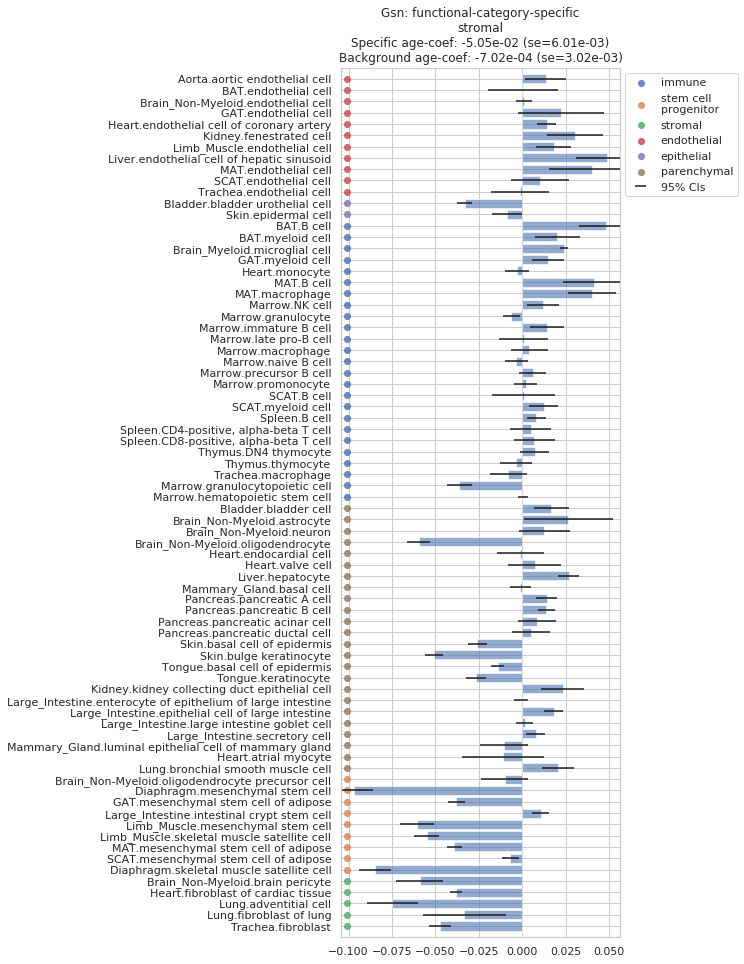

In [25]:
# Visualizing single gene
gene_plot_list = [('C2cd4b', 'spec_func:parenchymal'),
                  ('Gsn', 'spec_func:stromal')]
method = 'facs'

for term in gene_plot_list:
    
    gene,spec_term_name = term
    spec_name = spec_term_name.split(':')[0]
    
    term_list = [x for x in dic_gene_anno['%s_table'%method].columns if (spec_name in x)]
    term_list.sort()
    
    # Get analyte_list
    temp_df = dic_anno[method].sort_values(by=dic_spec_col[spec_name])
    analyte_list = list(temp_df.index)
    
    df_plot = pd.DataFrame(index=analyte_list)
    df_plot['mean'] = dic_coef[method].loc[gene, analyte_list]
    df_plot['se'] = dic_coef_se[method].loc[gene, analyte_list]
    df_plot['loc'] = np.arange(df_plot.shape[0])[::-1]
    
    plt.figure(figsize=[5,16])
    plt.barh(df_plot['loc'], df_plot['mean'], alpha=0.6)
    plt.errorbar(df_plot['mean'], df_plot['loc'], xerr=1.96*df_plot['se'],
                     fmt='none', color='k', label='95% CIs')
    plt.yticks(df_plot['loc'], df_plot['loc'].index)
    xmin_,xmax_ = plt.xlim()
    xmin_ = max(xmin_, df_plot['mean'].min() - (df_plot['mean'].max()-df_plot['mean'].min())*0.05) 
    xmax_ = min(xmax_, df_plot['mean'].max() + (df_plot['mean'].max()-df_plot['mean'].min())*0.05) 
    plt.xlim([xmin_, xmax_])
    
    # Category annotation
    xmin_,xmax_ = plt.xlim()
    if spec_name=='spec_func':
        for i_cellcate,cellcate in enumerate(CELLCATE_LIST):
            ind_select = np.array([dic_anno[method].loc[x, 'cell category'].split(';')[0]==cellcate
                                   for x in df_plot.index])
            plt.scatter([xmin_+0.02*(xmax_-xmin_)]*ind_select.sum(), 
                        df_plot.loc[ind_select, 'loc'], 
                        color='C%d'%i_cellcate, alpha=0.8, label=cellcate.replace('/', '\n'))
    else:
        temp_list = list(set(dic_anno[method][dic_spec_col[spec_name][0]].values))
        temp_list.sort()
        for i_term,term in enumerate(temp_list):
            if term!= spec_term_name.split(':')[1]: continue
            label = dic_spec_col[spec_name][0] if i_term==0 else None
            ind_select = np.array([term==dic_anno[method].loc[x, dic_spec_col[spec_name][0]]
                                   for x in df_plot.index])
            plt.scatter([xmin_+0.02*(xmax_-xmin_)]*ind_select.sum(), 
                        df_plot.loc[ind_select, 'loc'], 
                        color='C%d'%(i_term%6), alpha=0.8, label=label)
                
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.title('%s: %s\n'%(gene, dic_spec_name[spec_name]) + 
              '%s\n'%(spec_term_name.split(':')[1]) +
              'Specific age-coef: %0.2e (se=%0.2e)\n'
              %(dic_gene_anno[method].loc[gene, '%s.mean'%spec_term_name],
                dic_gene_anno[method].loc[gene, '%s.se'%spec_term_name]) + 
              'Background age-coef: %0.2e (se=%0.2e)'
              %(dic_gene_anno[method].loc[gene, '%s.mean_ref'%spec_term_name],
                dic_gene_anno[method].loc[gene, '%s.se_ref'%spec_term_name]))
    plt.savefig(DATA_PATH+'/result_v1/fig_spec/gene_%s_%s_%s.pdf'%(gene,method,spec_name),
                    transparent=True, bbox_inches='tight')
    
    plt.ylim([-1, df_plot.shape[0]])
    plt.show()

### Pathway GAG perturbation 

In [26]:
# Pathway analysis 
start_time = time.time()
dic_GAG_pathway = {}
p_sig_list = [0.4,0.5,0.6,0.7,0.8] 
method='facs'

for p_sig in p_sig_list:
    temp_gene_list = list(dic_gene_anno[method].index[dic_gene_anno[method]['prop_sig_w']>p_sig])
    gp = GProfiler(return_dataframe=True)
    temp_df = gp.profile(organism='mmusculus', query=temp_gene_list,
                         sources=['GO:BP'], significance_threshold_method='fdr', 
                         user_threshold=0.01, background=dic_gene_list[method])
    dic_GAG_pathway[p_sig] = temp_df.copy()
    print('# %-8s %0.1f n_gene=%-5d time=%0.1fs'%(method, p_sig, len(temp_gene_list), time.time()-start_time))

# facs     0.4 n_gene=697   time=7.8s
# facs     0.5 n_gene=330   time=13.3s
# facs     0.6 n_gene=144   time=18.1s
# facs     0.7 n_gene=47    time=22.1s
# facs     0.8 n_gene=18    time=25.5s


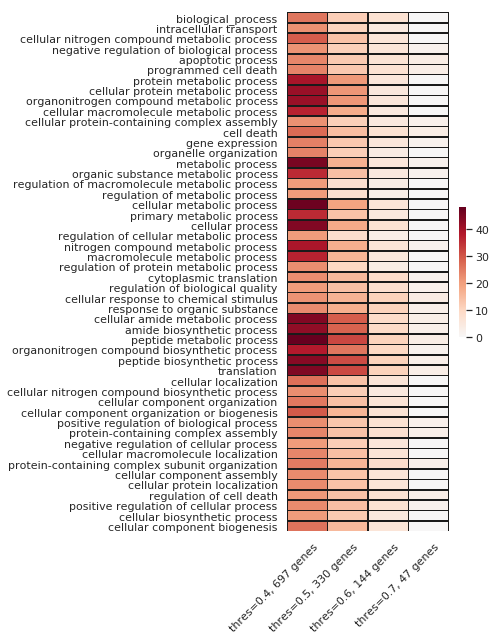

In [27]:
# Figure
df_pathway = pd.DataFrame()
for p_sig in p_sig_list:

    temp_df = dic_GAG_pathway[p_sig].copy()
    temp_df.index = temp_df['name']
    temp_df['nlog_fdr'] = -np.log10(temp_df['p_value'].values)
    temp_df = temp_df[['nlog_fdr']]
    temp_df.columns = [p_sig]
    df_pathway = df_pathway.join(temp_df, how='outer')

df_pathway = df_pathway.fillna(0)

df_plot = df_pathway.copy()
if df_plot.shape[0]>50:
    temp_thres = np.sort(df_plot.max(axis=1))[::-1][50]
    df_plot = df_plot.loc[df_plot.max(axis=1)>temp_thres]
df_plot = df_plot.drop(labels=list(df_plot.columns[df_plot.sum(axis=0)==0]), axis=1)

if df_plot.shape[1]>1:
    temp_y = sp.spatial.distance.pdist(df_plot.values, metric='correlation')
    temp_linkage = sp.cluster.hierarchy.linkage(temp_y, method='average')
    ind_sort = list(df_plot.index[sp.cluster.hierarchy.leaves_list(temp_linkage)])
    df_plot = df_plot.loc[ind_sort]

plt.figure(figsize=[5 + 0.5*df_plot.shape[1] ,3+0.12*df_plot.shape[0]])
sns.heatmap(df_plot, xticklabels=True, yticklabels=True,
            cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.25},
            linewidths=.5, linecolor='k')
plt.xticks(np.arange(df_plot.shape[1])+0.8, 
           ['thres=%s, %d genes'%(x, (dic_gene_anno[method]['prop_sig_w']>float(x)).sum()) for x in df_plot.columns],
           rotation=45, ha='right')
plt.ylabel('')
plt.tight_layout()
# plt.title('GO enrichment analysis for\n%s genes'%temp_name_dic[spec_name])
plt.savefig(DATA_PATH+'/result_v1/fig_pathway/pathway_GAG_perturbation.pdf',
            bbox_inches='tight', transparent=True)
plt.show()

### Pathway analysis (./result_v1/fig_pathway)

In [28]:
# Pathway analysis 
start_time = time.time()
dic_pathway = {}

for method in METHOD_LIST:
    
    temp_df_table = dic_gene_anno['%s_table'%method]
    temp_list = [x for x in temp_df_table.columns if ('global' in x) | ('spec' in x)]
    
    for term in temp_list:
        temp_gene_list = list(temp_df_table.index[temp_df_table[term].values])
        
        if len(temp_gene_list)<10: continue
            
        gp = GProfiler(return_dataframe=True)
        temp_df = gp.profile(organism='mmusculus', query=temp_gene_list,
                             sources=['GO:BP'], significance_threshold_method='fdr', 
                             user_threshold=0.01, background=dic_gene_list[method])

        dic_pathway['%s:%s'%(method,term)] = temp_df.copy()
        print('# %-8s %-32s n_gene=%-5d time=%0.1fs'%(method, term, len(temp_gene_list), time.time()-start_time))

# facs     global_aging                     n_gene=330   time=5.4s
# facs     spec_celltype:B cell             n_gene=90    time=9.0s
# facs     spec_celltype:basal cell of epidermis n_gene=249   time=12.9s
# facs     spec_celltype:endothelial cell   n_gene=45    time=16.2s
# facs     spec_celltype:mesenchymal stem cell n_gene=174   time=19.7s
# facs     spec_celltype:mesenchymal stem cell of adipose n_gene=98    time=23.1s
# facs     spec_celltype:myeloid cell       n_gene=38    time=26.6s
# facs     spec_celltype:skeletal muscle satellite cell n_gene=249   time=31.3s
# facs     spec_func:endothelial            n_gene=61    time=34.6s
# facs     spec_func:epithelial             n_gene=14    time=37.9s
# facs     spec_func:immune                 n_gene=63    time=41.7s
# facs     spec_func:parenchymal            n_gene=20    time=45.2s
# facs     spec_func:stem cell/progenitor   n_gene=76    time=48.8s
# facs     spec_func:stromal                n_gene=74    time=52.1s
# facs     spec_

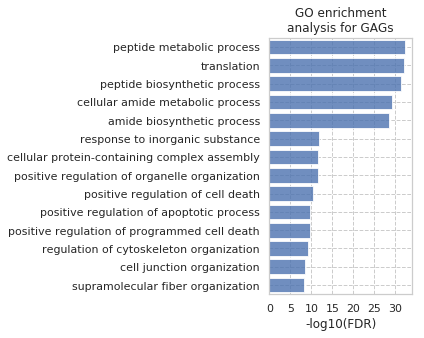

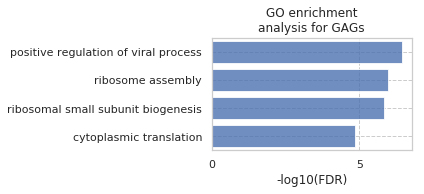

In [29]:
# Pathway: global aging
for method in METHOD_LIST:
    
    temp_df = dic_pathway['%s:global_aging'%method].copy()
    temp_df.index = temp_df['name']
    ind_select = (temp_df['term_size']<1000) & (temp_df['precision']>0.1) & (temp_df['recall']>0.05)
    temp_df = temp_df.loc[ind_select].copy()
        
    df_plot = temp_df[['p_value']].copy()
    df_plot['nlog_fdr'] = -np.log10(df_plot['p_value'].values)
    if df_plot.shape[0]>50:
        df_plot = df_plot.iloc[:50]
    df_plot['loc'] = np.arange(df_plot.shape[0])[::-1]
    
    plt.figure(figsize=[6, 2+df_plot.shape[0]*0.2])
    plt.barh(df_plot['loc'], df_plot['nlog_fdr'], alpha=0.8)
    plt.yticks(df_plot['loc'].values, df_plot.index, rotation=0, ha='right')
    plt.xlabel('-log10(FDR)')
    plt.ylim([-0.5, df_plot.shape[0]-0.5])
    xmin_,xmax_ = plt.xlim()
    temp_ = [5*x for x in np.arange(10) if 5*x<xmax_]
    plt.xticks(temp_, temp_)
    
    plt.grid(linestyle='--')
    plt.title('GO enrichment\nanalysis for GAGs')
    plt.tight_layout()
    plt.savefig(DATA_PATH+'/result_v1/fig_pathway/pathway_global_%s.pdf'%method, bbox_inches='tight')
    plt.show()
#     break

facs spec_func (49, 4)


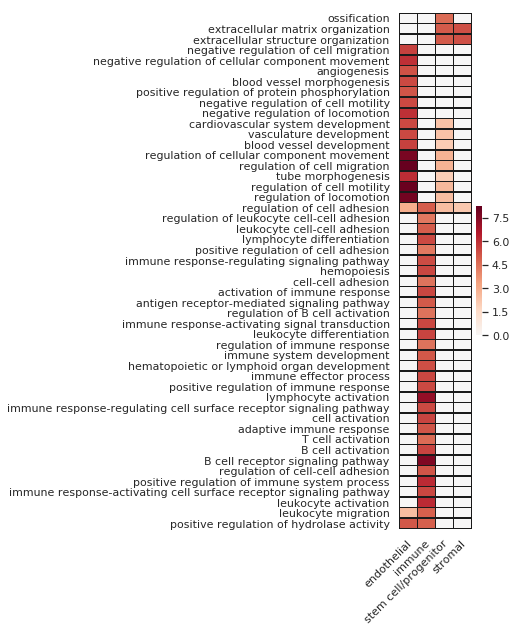

facs spec_celltype (50, 5)


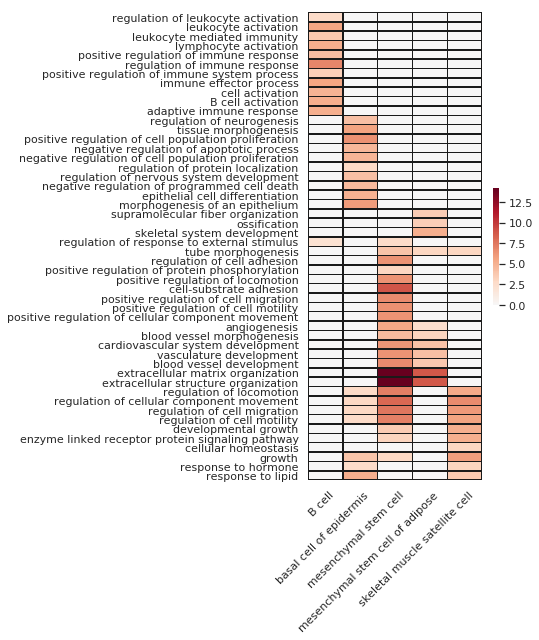

facs spec_tissue (49, 14)


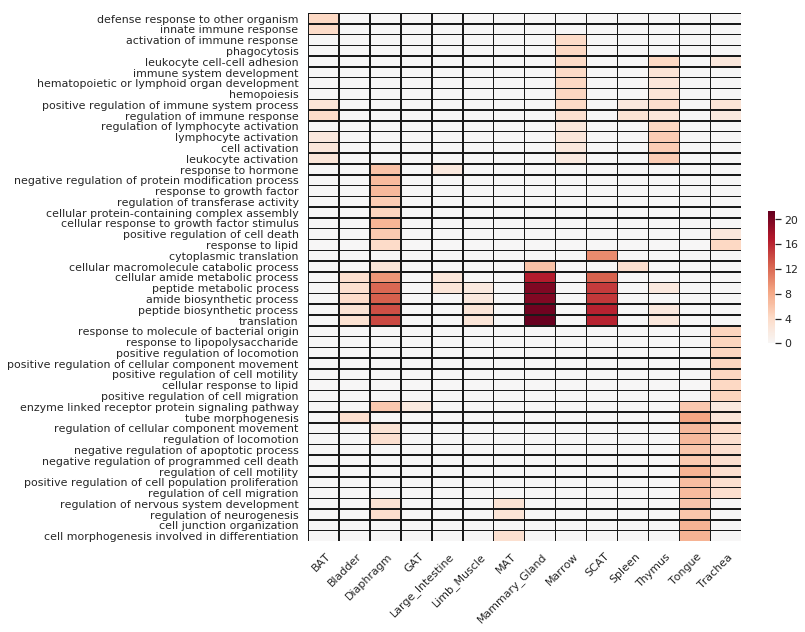

droplet spec_func (49, 3)


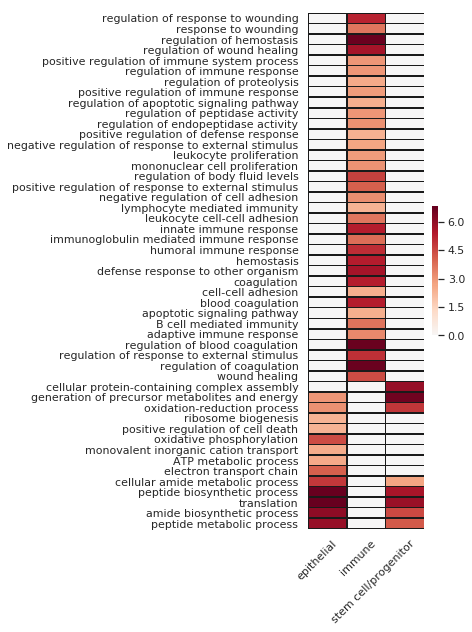

droplet spec_celltype (50, 2)


/home/jz286/myenv/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


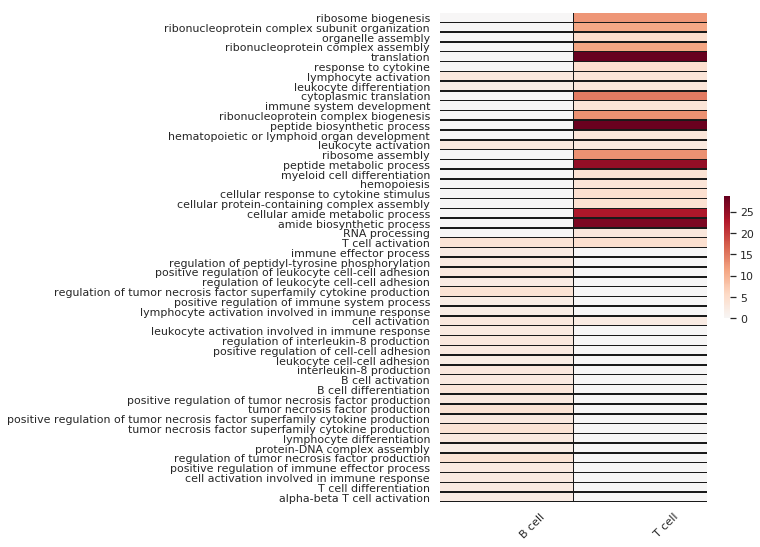

droplet spec_tissue (49, 6)


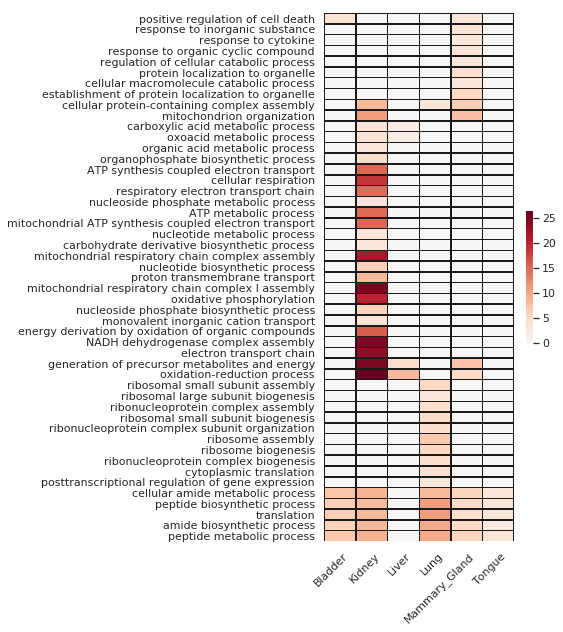

In [30]:
# Pathway: specific genes 
spec_list = ['spec_func', 'spec_celltype', 'spec_tissue', 'spec_tissue_celltype']
temp_name_dic = {'spec_func': 'functional-category-specific',
                 'spec_celltype': 'cell-type-specific',
                 'spec_tissue': 'tissue-specific',
                 'spec_tissue_celltype': 'tissue-cell-type-specific'}

for method in METHOD_LIST:
    for spec_name in spec_list:
        
        term_list = [x for x in dic_pathway.keys() if (spec_name in x) & (method in x)]
        term_list.sort()
        if len(term_list)==0:
            continue
        
        df_pathway = pd.DataFrame()
        for term in term_list:

            temp_df = dic_pathway[term].copy()
            temp_df.index = temp_df['name']
            temp_df['nlog_fdr'] = -np.log10(temp_df['p_value'].values)
#             ind_select = (temp_df['term_size']<750) & (temp_df['precision']>0.05) & (temp_df['recall']>0.05)
            ind_select = (temp_df['term_size']<1000) & (temp_df['precision']>0.1)
            temp_df = temp_df.loc[ind_select, ['nlog_fdr']]
            temp_df.columns = [term]
            df_pathway = df_pathway.join(temp_df, how='outer')

        df_pathway = df_pathway.fillna(0)

        df_plot = df_pathway.copy()
        if df_plot.shape[0]>50:
            temp_thres = np.sort(df_plot.max(axis=1))[::-1][50]
            df_plot = df_plot.loc[df_plot.max(axis=1)>temp_thres]
        df_plot = df_plot.drop(labels=list(df_plot.columns[df_plot.sum(axis=0)==0]), axis=1)
        
        if df_plot.shape[1]>1:
            temp_y = sp.spatial.distance.pdist(df_plot.values, metric='correlation')
            temp_linkage = sp.cluster.hierarchy.linkage(temp_y, method='average')
            ind_sort = list(df_plot.index[sp.cluster.hierarchy.leaves_list(temp_linkage)])
            df_plot = df_plot.loc[ind_sort]
            
        print(method, spec_name, df_plot.shape)

        plt.figure(figsize=[5 + 0.5*df_plot.shape[1] ,3+0.12*df_plot.shape[0]])
        sns.heatmap(df_plot, xticklabels=True, yticklabels=True,
                    cmap = 'RdBu_r', center=0, cbar_kws={"shrink": 0.25},
                    linewidths=.5, linecolor='k')
        plt.xticks(np.arange(df_plot.shape[1])+0.8, 
                   [x.replace('%s:%s:'%(method, spec_name),'') for x in df_plot.columns],
                   rotation=45, ha='right')
        plt.ylabel('')
        plt.tight_layout()
#         plt.title('GO enrichment analysis for\n%s genes'%temp_name_dic[spec_name])
        plt.savefig(DATA_PATH+'/result_v1/fig_pathway/pathway_%s_%s.pdf'%(spec_name,method),
                    bbox_inches='tight', transparent=True)
        plt.show()